# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [116]:
# Import warnings
import warnings
# warnings.filterwarnings('ignore')
warnings.warn("generate warning using warn")

/tmp/ipykernel_27119/1329735581.py:4: UserWarning: generate warning using warn
  warnings.warn("generate warning using warn")


In [2]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from itertools import islice

In [3]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
# print("numpy version:", np.__version__)
# print("pandas version:", pd.__version__){
# print("matplotlib version:", plt.matplotlib.__version__)
# print("seaborn version:", sns.__version__)

### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [16]:
# Try loading one file

df = pd.read_parquet('/home/rv/upgrad/nyc_taxi/Datasets and Dictionary/trip_records/2023-1.parquet')
# df.info()

In [4]:
# Adding two derived columns
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

#### Creating dictionary for all the unique days 

data_per_day = {'day1' : **_data_frame_**,  'day2' : **_data_frame_** .. }

In [6]:

days_dict = {}
numberofdays = df["pickup_day"].unique()
for i in numberofdays:
    days_dict["day_" + str(i) ] = df [ df ["pickup_day"]==i ]
days_dict[ "day_1" ]

sampled_data = pd.DataFrame()

for x in islice( days_dict, 1 ):
    for y in range(0, 24):
            hour =  days_dict[x][  days_dict[ x ].pickup_hour == y  ]
            sample = hour.sample( frac= 0.05, random_state = 41 )            
            sampled_data = pd.concat( [sampled_data, sample] )
sampled_data

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
394           2  2023-01-01 00:34:23   2023-01-01 00:45:56              2.0   
2324          2  2023-01-01 00:48:56   2023-01-01 00:58:49              1.0   
177           1  2023-01-01 00:18:35   2023-01-01 00:28:21              1.0   
1787          2  2023-01-01 00:22:59   2023-01-01 00:30:27              2.0   
2647          2  2023-01-01 00:38:47   2023-01-01 00:42:31              2.0   
...         ...                  ...                   ...              ...   
72060         2  2023-01-01 23:06:45   2023-01-01 23:12:30              2.0   
72808         1  2023-01-01 23:19:20   2023-01-01 23:31:52              1.0   
72482         1  2023-01-01 23:49:18   2023-01-01 23:54:35              2.0   
72201         2  2023-01-01 23:16:14   2023-01-01 23:26:15              3.0   
73046         1  2023-01-01 23:09:23   2023-01-01 23:26:28              1.0   

       trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
394             2.04         1.0                  N           239   
2324            1.76         1.0                  N           166   
177             1.60         1.0                  N           107   
1787            1.40         1.0                  N           143   
2647            0.48         1.0                  N           164   
...              ...         ...                ...           ...   
72060           1.26         1.0                  N           144   
72808           2.70         1.0                  N           143   
72482           1.60         1.0                  N           233   
72201           1.49         1.0                  N            79   
73046           8.90         1.0                  N           138   

       DOLocationID  payment_type  ...  extra  mta_tax  tip_amount  \
394             140             1  ...   1.00      0.5        3.70   
2324             42             1  ...   1.00      0.5        2.92   
177             249             1  ...   3.50      0.5        3.00   
1787            151             2  ...   1.00      0.5        0.00   
2647            186             1  ...   1.00      0.5        2.16   
...             ...           ...  ...    ...      ...         ...   
72060           107             1  ...   1.00      0.5        5.00   
72808           263             1  ...   3.50      0.5        1.99   
72482           141             1  ...   3.50      0.5        1.70   
72201           158             1  ...   1.00      0.5        3.14   
73046           208             1  ...   7.25      0.5       10.35   

       tolls_amount  improvement_surcharge  total_amount  \
394            0.00                    1.0         22.20   
2324           0.00                    1.0         17.52   
177            0.00                    1.0         18.00   
1787           0.00                    1.0         15.00   
2647           0.00                    1.0         12.96   
...             ...                    ...           ...   
72060          0.00                    1.0         17.90   
72808          0.00                    1.0         21.89   
72482          0.00                    1.0         16.00   
72201          0.00                    1.0         18.84   
73046          6.55                    1.0         62.25   

       congestion_surcharge  airport_fee  pickup_day  pickup_hour  
394                     2.5         0.00           1            0  
2324                    0.0         0.00           1            0  
177                     2.5         0.00           1            0  
1787                    2.5         0.00           1            0  
2647                    2.5         0.00           1            0  
...                     ...          ...         ...          ...  
72060                   2.5         0.00           1           23  
72808                   2.5         0.00           1           23  
72482                   2.5         0.00           1   

In [7]:
# verifying randomness spread
sampled_data.pickup_hour.value_counts(sort="true")


pickup_hour
1     286
0     265
2     253
15    214
14    211
16    211
17    203
13    198
3     195
12    190
18    184
19    171
11    167
20    143
21    138
10    133
22    129
4     123
23    101
9      82
8      56
5      54
7      50
6      44
Name: count, dtype: int64

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [16]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

In [12]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
os.chdir('/home/rv/upgrad/nyc_taxi/Datasets and Dictionary/trip_records')
# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
sampled_data = pd.DataFrame()


# iterate through the list of files and sample one by one:
for file_name in  file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file
        df = pd.read_parquet(file_path)
        df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
        df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
        


        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        daily_sampled = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date
        days_dict = {}
        # numberofdays = sorted( df["day_of_month"].unique() )
        numberofdays = df["pickup_day"].unique()
        for i in numberofdays:
           days_dict["day_" + str(i) ] = df [ df ["pickup_day"]==i ]
        
        # days_dict[ "day_1" ]
        for day in days_dict:
            # Iterate through each hour of the selected date
            for hour in range(0, 24):
            # Sample 5% of the hourly data randomly
                sample =  days_dict[day][ days_dict[ day ].pickup_hour == hour ].sample( frac= 0.05, random_state = 41 )            
                # add data of this hour to the dataframe
                daily_sampled = pd.concat( [daily_sampled, sample] )
        
        sampled_data = pd.concat( [daily_sampled, sampled_data] )   

        # Concatenate the sampled data of all the dates to a single dataframe
    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

In [13]:
sampled_data.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
549          2  2023-11-01 00:54:20   2023-11-01 00:58:10              2.0   
1851         2  2023-11-01 00:40:13   2023-11-01 01:00:09              1.0   
59           2  2023-11-01 00:25:07   2023-11-01 00:29:11              5.0   
2107         2  2023-11-01 00:17:26   2023-11-01 00:27:06              1.0   
1921         2  2023-11-01 00:19:03   2023-11-01 00:23:10              1.0   

      trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
549            1.24         1.0                  N           158   
1851           5.73         1.0                  N           158   
59             1.61         1.0                  N           237   
2107           1.36         1.0                  N           114   
1921           1.02         1.0                  N           249   

      DOLocationID  payment_type  ...  mta_tax  tip_amount  tolls_amount  \
549             90             1  ...      0.5        2.44          0.00   
1851           228             1  ...      0.5       11.62          6.94   
59             263             2  ...      0.5        0.00          0.00   
2107            79             1  ...      0.5        3.14          0.00   
1921           234             1  ...      0.5        1.50          0.00   

      improvement_surcharge  total_amount  congestion_surcharge  Airport_fee  \
549                     1.0         14.64                   2.5          0.0   
1851                    1.0         50.36                   2.5          0.0   
59                      1.0         13.60                   2.5          0.0   
2107                    1.0         18.84                   2.5          0.0   
1921                    1.0         13.70                   2.5          0.0   

      pickup_day  pickup_hour  airport_fee  
549            1            0          NaN  
1851           1            0          NaN  
59             1            0          NaN  
2107           1            0          NaN  
1921           1            0          NaN  

[5 rows x 22 columns]

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [14]:
# Store the df in csv/parquet
sampled_data.to_parquet('/home/rv/upgrad/nyc_taxi/sample.parquet')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [1]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
# Load the new data file
df_data = pd.read_parquet('/home/rv/upgrad/nyc_taxi/sample.parquet');
# df_data.head()


#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [2]:
# Fix the index and drop any columns that are not needed
df = df_data.reset_index(drop = True)
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-11-01 00:54:20   2023-11-01 00:58:10              2.0   
1         2  2023-11-01 00:40:13   2023-11-01 01:00:09              1.0   
2         2  2023-11-01 00:25:07   2023-11-01 00:29:11              5.0   
3         2  2023-11-01 00:17:26   2023-11-01 00:27:06              1.0   
4         2  2023-11-01 00:19:03   2023-11-01 00:23:10              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.24         1.0                  N           158            90   
1           5.73         1.0                  N           158           228   
2           1.61         1.0                  N           237           263   
3           1.36         1.0                  N           114            79   
4           1.02         1.0                  N           249           234   

   payment_type  ...  mta_tax  tip_amount  tolls_amount  \
0             1  ...      0.5        2.44          0.00   
1             1  ...      0.5       11.62          6.94   
2             2  ...      0.5        0.00          0.00   
3             1  ...      0.5        3.14          0.00   
4             1  ...      0.5        1.50          0.00   

   improvement_surcharge  total_amount  congestion_surcharge  Airport_fee  \
0                    1.0         14.64                   2.5          0.0   
1                    1.0         50.36                   2.5          0.0   
2                    1.0         13.60                   2.5          0.0   
3                    1.0         18.84                   2.5          0.0   
4                    1.0         13.70                   2.5          0.0   

   pickup_day  pickup_hour  airport_fee  
0           1            0          NaN  
1           1            0          NaN  
2           1            0          NaN  
3           1            0          NaN  
4           1            0          NaN  

[5 rows x 22 columns]

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [4]:
def delete_columns_if_exist(dataframe, columns_to_delete):
    existing_columns = dataframe.columns.intersection(columns_to_delete)
    dataframe = dataframe.drop(columns=existing_columns)
    return dataframe

In [5]:
# Combine the two airport fee columns
df["airport_surcharge"] = df["airport_fee"].combine_first(df["Airport_fee"])

# Delete the two columns
df = delete_columns_if_exist(df, ["Airport_fee", "airport_fee"])
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-11-01 00:54:20   2023-11-01 00:58:10              2.0   
1         2  2023-11-01 00:40:13   2023-11-01 01:00:09              1.0   
2         2  2023-11-01 00:25:07   2023-11-01 00:29:11              5.0   
3         2  2023-11-01 00:17:26   2023-11-01 00:27:06              1.0   
4         2  2023-11-01 00:19:03   2023-11-01 00:23:10              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.24         1.0                  N           158            90   
1           5.73         1.0                  N           158           228   
2           1.61         1.0                  N           237           263   
3           1.36         1.0                  N           114            79   
4           1.02         1.0                  N           249           234   

   payment_type  ...  extra  mta_tax  tip_amount  tolls_amount  \
0             1  ...    1.0      0.5        2.44          0.00   
1             1  ...    1.0      0.5       11.62          6.94   
2             2  ...    1.0      0.5        0.00          0.00   
3             1  ...    1.0      0.5        3.14          0.00   
4             1  ...    1.0      0.5        1.50          0.00   

   improvement_surcharge  total_amount  congestion_surcharge  pickup_day  \
0                    1.0         14.64                   2.5           1   
1                    1.0         50.36                   2.5           1   
2                    1.0         13.60                   2.5           1   
3                    1.0         18.84                   2.5           1   
4                    1.0         13.70                   2.5           1   

   pickup_hour  airport_surcharge  
0            0                0.0  
1            0                0.0  
2            0                0.0  
3            0                0.0  
4            0                0.0  

[5 rows x 21 columns]

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [6]:
def find_nve_columns(df):
    numerical = df.select_dtypes(include='number').columns
    return numerical[(df[ numerical ]< 0 ).any()]
find_nve_columns(df)

Index(['extra', 'mta_tax', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'airport_surcharge'],
      dtype='object')

In [7]:
invalid_cols = ['extra', 'mta_tax', 'improvement_surcharge', 'total_amount',
                'congestion_surcharge', 'airport_surcharge']
print("negative values count")
for col in invalid_cols:
    neg_count = df[df[col] < 0].shape[0]
    print(f"{col.ljust(24)}: {neg_count}") 

negative values count
extra                   : 1
mta_tax                 : 76
improvement_surcharge   : 83
total_amount            : 83
congestion_surcharge    : 66
airport_surcharge       : 15


In [8]:
# check where values of fare amount are negative
# Filter rows with negative fare amount
negative_data = df[
    (df['fare_amount'] < 0) |
    (df['extra'] < 0) |
    (df['mta_tax'] < 0) |
    (df['tip_amount'] < 0) |
    (df['tolls_amount'] < 0) |
    (df['improvement_surcharge'] < 0) |
    (df['total_amount'] < 0) |
    (df['congestion_surcharge'] < 0) |
    (df['airport_surcharge'] < 0)
]

# Display the filtered records
negative_data

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
258             2  2023-11-01 02:04:32   2023-11-01 02:05:06              1.0   
9425            2  2023-11-02 16:43:40   2023-11-02 16:43:47              1.0   
26744           2  2023-11-05 12:12:44   2023-11-05 12:16:06              1.0   
30345           2  2023-11-06 06:37:02   2023-11-06 06:45:16              1.0   
42720           2  2023-11-08 12:49:39   2023-11-08 13:55:00              1.0   
...           ...                  ...                   ...              ...   
1823340         2  2023-10-16 18:27:28   2023-10-16 18:27:55              1.0   
1831768         2  2023-10-18 10:58:37   2023-10-18 11:31:25              1.0   
1852920         2  2023-10-21 18:01:24   2023-10-21 18:16:52              2.0   
1877930         2  2023-10-26 23:06:28   2023-10-26 23:48:25              1.0   
1887728         2  2023-10-28 15:38:42   2023-10-28 16:04:37              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
258               0.17         1.0                  N            79   
9425              0.02         2.0                  N            90   
26744             0.60         2.0                  N           211   
30345             2.03         1.0                  N           236   
42720            17.30         2.0                  N           132   
...                ...         ...                ...           ...   
1823340           0.00         1.0                  N           163   
1831768           7.84         1.0                  N           138   
1852920           2.40         1.0                  N           137   
1877930           2.30         1.0                  N           262   
1887728           0.00         2.0                  N           132   

         DOLocationID  payment_type  ...  extra  mta_tax  tip_amount  \
258                79             3  ...   -1.0     -0.5         0.0   
9425               90             2  ...    0.0     -0.5         0.0   
26744             148             2  ...    0.0     -0.5         0.0   
30345             163             2  ...    0.0     -0.5         0.0   
42720             246             2  ...    0.0     -0.5         0.0   
...               ...           ...  ...    ...      ...         ...   
1823340           163             2  ...    0.0     -0.5         0.0   
1831768           237             2  ...    0.0     -0.5         0.0   
1852920           145             2  ...    0.0     -0.5         0.0   
1877930            74             2  ...    0.0     -0.5         0.0   
1887728            93             2  ...    0.0     -0.5         0.0   

         tolls_amount  improvement_surcharge  total_amount  \
258               0.0                   -1.0         -5.00   
9425              0.0                   -1.0         -4.00   
26744             0.0                   -1.0         -4.00   
30345             0.0                   -1.0         -4.00   
42720             0.0                   -1.0         -5.75   
...               ...                    ...           ...   
1823340           0.0                   -1.0         -4.00   
1831768           0.0                   -1.0         -5.75   
1852920           0.0                   -1.0         -4.00   
1877930           0.0                   -1.0         -4.00   
1887728           0.0                   -1.0         -3.25   

         congestion_surcharge  pickup_day  pickup_hour  airport_surcharge  
258                      -2.5           1            2               0.00  
9425                     -2.5           2           16               0.00  
26744                    -2.5           5           12               0.00  
30345                    -2.5           6            6               0.00  
42720                    -2.5           8           12              -1.75  
...                       ...         ...          ...                ...  
1823340                  -2.5          16

In [9]:
# check where values of fare amount are negative


Did you notice something different in the `RatecodeID` column for above records?

In [10]:
# fix these negative values
initial_set = df.shape[0]
print(f"Initial : {initial_set} rows")

df.drop(negative_data.index, inplace = True)

result_set = df.shape[0]
print(f"Dropping {initial_set - result_set} rows") 
print(f"Final : {result_set} rows")

Initial : 1896420 rows
Dropping 83 rows
Final : 1896337 rows


In [11]:
print( f"eliminating rides with no passengers and fare amounts " )
passenger_data = df[ ~(df[[ "passenger_count","fare_amount" ]]==0).all(1) ]
print( f"Dropping {df.shape[0]- passenger_data.shape[0]} rows " )
df = passenger_data

# Keep only valid RatecodeIDs (1-6) or NaN
valid_rc = df['RatecodeID'].isin([1, 2, 3, 4, 5, 6, np.nan])
print( f"seperating outlier Ratecode 99 data to a file")
print(f"outlier data with {df[-valid_rc].shape[0]} rows" ) 

# Flag the rows with RatecodeID == 99 for later review or model-based reclassification
rate99_df = df[~valid_rc]
df = df[valid_rc]

eliminating rides with no passengers and fare amounts 
Dropping 34 rows 
seperating outlier Ratecode 99 data to a file
outlier data with 10909 rows


In [12]:
# Analyse RatecodeID for the negative fare amounts

In [13]:
print("RatecodeID distribution")
print(df['RatecodeID'].value_counts())

print("\nRatecodeID distribution in fare_amount:")
print(negative_data['RatecodeID'].value_counts())

RatecodeID distribution
RatecodeID
1.0    1727470
2.0      72948
5.0      10597
3.0       6196
4.0       3824
6.0          4
Name: count, dtype: int64

RatecodeID distribution in fare_amount:
RatecodeID
1.0    46
2.0    30
5.0     5
3.0     2
Name: count, dtype: int64


### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [14]:
def list_missingval(dataframe):
    print(f"proportion of missing values")
    missing_values = pd.DataFrame( (df.isnull().mean().mul(100).round(3).sort_values(ascending=False)), columns=['ratio'])
    return missing_values[ missing_values["ratio"]>0 ]
list_missingval(df)

proportion of missing values


ratio
passenger_count       3.413
airport_surcharge     3.413
congestion_surcharge  3.413
store_and_fwd_flag    3.413
RatecodeID            3.413

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [15]:
df = df.copy()
print(f"imputing {df[df['passenger_count'].isna()].shape[0]} null values in passenger_count with median") 
# Fill missing values with the median
df['passenger_count'] = df['passenger_count'].fillna(df['passenger_count'].median())
# Check number of missing values after imputation
print(df[df['passenger_count'].isna()].shape[0])

imputing 64355 null values in passenger_count with median
0


In [16]:
# Imputing zeroes with median in passenger_count
print(df[(df['passenger_count'] == 0)].shape[0])
median_val = df['passenger_count'].median()
df['passenger_count'] = df['passenger_count'].replace(0, median_val)
print( df[(df['passenger_count']==0)].shape[0] )

29096
0


**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [17]:
# Fix missing values in 'RatecodeID'
print("since its categorical, taking mode of the column")
print(df['RatecodeID'].median())

# Count how many are missing before imputation
print(df[df['RatecodeID'].isna()].shape[0])

# Fill nulls with the median
df['RatecodeID'] = df['RatecodeID'].fillna(df['RatecodeID'].mode())

since its categorical, taking mode of the column
1.0
64355


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [18]:
df['day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'] >= 5 
print(f"{df[df['is_weekend']==True]['congestion_surcharge'].mean()}")
print(f"{df[df['is_weekend']==False]['congestion_surcharge'].mean()}")
print(f"no specific pattern observed for weekends")

2.313132130431265
2.3241392605144124
no specific pattern observed for weekends


In [19]:
df.congestion_surcharge.describe()

count    1.821039e+06
mean     2.321151e+00
std      6.443089e-01
min      0.000000e+00
25%      2.500000e+00
50%      2.500000e+00
75%      2.500000e+00
max      2.500000e+00
Name: congestion_surcharge, dtype: float64

In [20]:
# handle null values in congestion_surcharge

# Median congestionimprovement surcharge is 1
df1 = df[df['improvement_surcharge'] == 1]['congestion_surcharge'].median()
print(f"Median congestion_surcharge : {df1}")

# Median congestion surcharge when improvement surcharge is 0
df2 = df[df['improvement_surcharge'] == 0]['congestion_surcharge'].median()
print(f"Median congestion_surcharge : {df2}")

Median congestion_surcharge : 2.5
Median congestion_surcharge : 0.0


In [21]:
# Check the number of missing values in congestion_surcharge
print(df[df['congestion_surcharge'].isna()].shape[0])

# if improvement_surcharge is 1, congestion_surcharge is typically 2.5
mask_fill_2_5 = (df['congestion_surcharge'].isna()) & (df['improvement_surcharge'] == 1.0)
df.loc[mask_fill_2_5, 'congestion_surcharge'] = 2.5

# Fill the rest with 0
df['congestion_surcharge'] = df['congestion_surcharge'].fillna(0)

# Verify that there are no missing values left
print(df[df['congestion_surcharge'].isna()].shape[0])

64355
0


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [22]:
# Handle any remaining missing values
list_missingval(df)

proportion of missing values


ratio
store_and_fwd_flag  3.413
RatecodeID          3.413
airport_surcharge   3.413

In [23]:
# df['store_and_fwd_flag'].fillna('N')
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].fillna('N')

In [24]:
df.airport_surcharge.value_counts()

airport_surcharge
0.00    1658560
1.75     122328
1.25      40149
1.70          1
1.00          1
Name: count, dtype: int64

In [25]:
# Estimate missing 'airport_surcharge' values
null_airport_data = df['airport_surcharge'].isna()

# Calculate residual amount potentially attributable to Airport Fee
remainder_fee = round(
    df['total_amount']
    - df['fare_amount']
    - df['extra']
    - df['mta_tax']
    - df['tip_amount']
    - df['tolls_amount']
    - df['improvement_surcharge']
    - df['congestion_surcharge'],
    2
)

# Assign $1.75 or $1.25 where matched, otherwise default to $0
remainder_fee[~remainder_fee.isin([1.75, 1.25])] = 0

# Fill the missing values in 'Airport_Fee' using calculated estimates
df.loc[null_airport_data, 'airport_surcharge'] = remainder_fee[null_airport_data]

# Confirm values were imputed successfully
print(df['airport_surcharge'].value_counts())

print("airport_surcharge:", df['airport_surcharge'].isna().sum())

airport_surcharge
0.00    1722915
1.75     122328
1.25      40149
1.70          1
1.00          1
Name: count, dtype: int64
airport_surcharge: 0


In [26]:
df = df[(df['RatecodeID'].isnull()) | df['RatecodeID'].isin([1,2,3,4,5,6])]

# Count how many are missing before imputation
print(f"Imputing {df[df['RatecodeID'].isna()].shape[0]} null values with median")

# Fill nulls with the median
df['RatecodeID'] = df['RatecodeID'].fillna(df['RatecodeID'].median())

print(f"result nulls: {df[df['RatecodeID'].isna()].shape[0]}")

Imputing 64355 null values with median
result nulls: 0


In [27]:
df.shape

(1885394, 23)

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [28]:
# Describe the data and check if there are any potential outliers present
df.describe()
df.describe(percentiles=[.01, .25, .5, .75, .99])

# Check for potential out of place values in various columns

VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  1.885394e+06                     1885394                     1885394   
mean   1.739468e+00  2023-07-02 18:08:25.256412  2023-07-02 18:25:46.960494   
min    1.000000e+00         2009-01-01 05:56:45         2009-01-01 06:09:59   
1%     1.000000e+00  2023-01-05 16:43:15.660000  2023-01-05 17:00:23.690000   
25%    1.000000e+00  2023-04-02 14:48:04.250000  2023-04-02 15:07:50.250000   
50%    2.000000e+00         2023-06-27 13:55:03  2023-06-27 14:15:40.500000   
75%    2.000000e+00  2023-10-06 18:47:20.750000         2023-10-06 19:04:31   
99%    2.000000e+00  2023-12-27 12:38:22.700000  2023-12-27 12:54:01.840000   
max    6.000000e+00         2023-12-31 23:59:57         2024-01-01 09:51:56   
std    4.438878e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     1.885394e+06   1.885394e+06  1.885394e+06  1.885394e+06   
mean      1.375959e+00   4.004420e+00  1.073841e+00  1.653899e+02   
min       1.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00   
1%        1.000000e+00   0.000000e+00  1.000000e+00  2.400000e+01   
25%       1.000000e+00   1.040000e+00  1.000000e+00  1.320000e+02   
50%       1.000000e+00   1.790000e+00  1.000000e+00  1.620000e+02   
75%       1.000000e+00   3.400000e+00  1.000000e+00  2.340000e+02   
99%       5.000000e+00   2.027000e+01  3.000000e+00  2.640000e+02   
max       9.000000e+00   1.445612e+05  6.000000e+00  2.650000e+02   
std       8.680162e-01   1.741373e+02  3.932177e-01  6.386068e+01   

       DOLocationID  payment_type   fare_amount  ...       mta_tax  \
count  1.885394e+06  1.885394e+06  1.885394e+06  ...  1.885394e+06   
mean   1.642224e+02  1.164972e+00  1.985017e+01  ...  4.951864e-01   
min    1.000000e+00  0.000000e+00  0.000000e+00  ...  0.000000e+00   
1%     9.000000e+00  0.000000e+00  4.400000e+00  ...  5.000000e-01   
25%    1.140000e+02  1.000000e+00  9.300000e+00  ...  5.000000e-01   
50%    1.620000e+02  1.000000e+00  1.350000e+01  ...  5.000000e-01   
75%    2.340000e+02  1.000000e+00  2.190000e+01  ...  5.000000e-01   
99%    2.640000e+02  3.000000e+00  7.830000e+01  ...  5.000000e-01   
max    2.650000e+02  4.000000e+00  9.950000e+02  ...  5.750000e+00   
std    6.981026e+01  5.094061e-01  1.837206e+01  ...  4.937689e-02   

         tip_amount  tolls_amount  improvement_surcharge  total_amount  \
count  1.885394e+06  1.885394e+06           1.885394e+06  1.885394e+06   
mean   3.578944e+00  5.978718e-01           9.990963e-01  2.896850e+01   
min    0.000000e+00  0.000000e+00           0.000000e+00  0.000000e+00   
1%     0.000000e+00  0.000000e+00           1.000000e+00  8.900000e+00   
25%    1.000000e+00  0.000000e+00           1.000000e+00  1.596000e+01   
50%    2.860000e+00  0.000000e+00           1.000000e+00  2.100000e+01   
75%    4.480000e+00  0.000000e+00           1.000000e+00  3.090000e+01   
99%    1.786000e+01  6.940000e+00           1.000000e+00  1.044100e+02   
max    7.118800e+02  6.655600e+02           1.000000e+00  9.960000e+02   
std    4.116813e+00  2.240744e+00           2.762087e-02  2.300279e+01   

       congestion_surcharge    pickup_day   pickup_hour  airport_surcharge  \
count          1.885394e+06  1.885394e+06  1.885394e+06       1.885394e+06   
mean           2.326451e+00  1.551685e+01  1.428381e+01       1.401632e-01   
min            0.000000e+00  1.000000e+00  0.000000e+00       0.000000e+00   
1%             0.000000e+00  1.000000e+00  0.000000e+00       0.000000e+00   
25%            2.500000e+00  8.000000e+00  1.100000e+01       0.000000e+00   
50%            2.500000e+00  1.500000e+01  1.500000e+01       0.000000e+00   
75%            2.500000e+00  2.300000e+01  1.900000e+01       0.000000e+00   
99%            2.500000e+00  3.100000e+01  2.300000e+01       1.750000e+00   
max            2.500000e+00  3.100000e+01  2.300000e+01       1.750000e+00   
std            

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

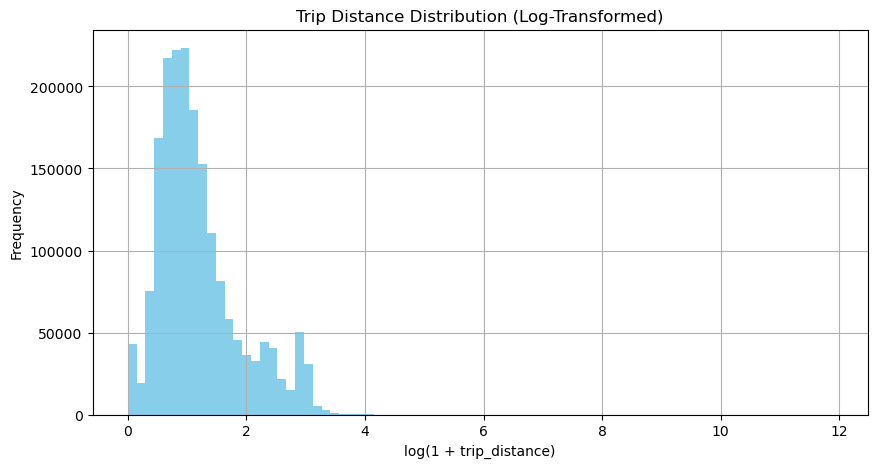

In [29]:

plt.figure(figsize=(10,5))
plt.hist(np.log1p(df['trip_distance']), bins=80, color='skyblue')
plt.title("Trip Distance Distribution (Log-Transformed)")
plt.xlabel("log(1 + trip_distance)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

How will you fix each of these values? Which ones will you drop and which ones will you replace?

In [30]:
df[~df['store_and_fwd_flag'].isin(['Y', 'N'])]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, pickup_day, pickup_hour, airport_surcharge, day_of_week, is_weekend]
Index: []

[0 rows x 23 columns]

In [31]:
# fare_amount > 0 and total_amount is 0  
# trip distance and fare amount is zero
# fare amount is 0 but trip distance is greater
# total amount is 0
# passenger count is greater 
# total amount greater than fare amount
inconsistent_mask = (
    ((df['trip_distance'] < 0.1) & (df['fare_amount'] > 300)) |
    ((df['trip_distance'] == 0) & (df['fare_amount'] == 0) & (df['PULocationID'] != df['DOLocationID'])) |
    (df.trip_distance>250) |
    ((df['trip_distance'] > 0) & (df['fare_amount'] == 0)) |
    (df['total_amount'] <= 0) |
    (df['tip_amount'] > df['fare_amount']) |
    (df['passenger_count']>6)
    |
    ((df['fare_amount'] > 0) & (df['total_amount'] == 0)) 
)
inconsistent_rows =  df[inconsistent_mask]
print(f"{len(inconsistent_rows)} inconsisent rows dropped")
df = df[~inconsistent_mask]

3025 inconsisent rows dropped


First, let us remove 7+ passenger counts as there are very less instances.

In [32]:
# remove passenger_count > 6


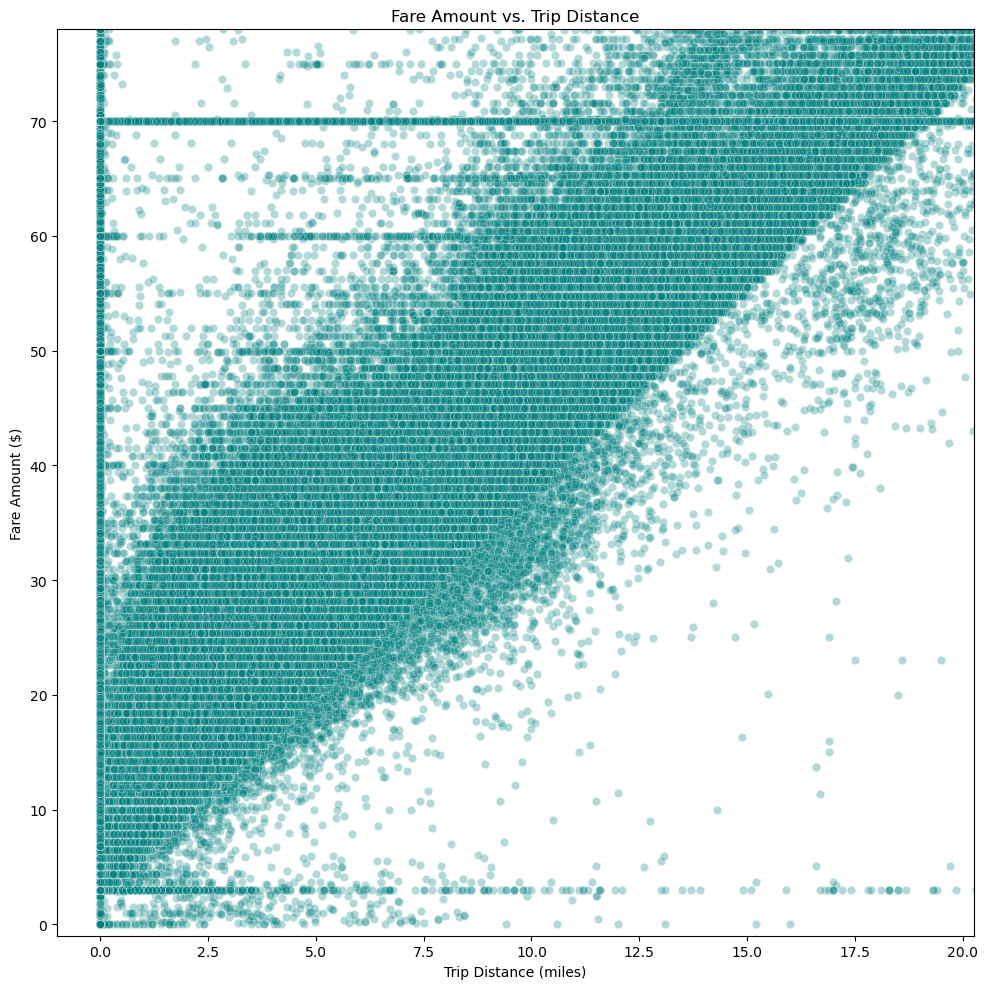

In [33]:
# Continue with outlier handling
# Set up the plot dimensions
plt.figure(figsize=(10, 10))

# Generate the scatter plot
sns.scatterplot(
    x=df['trip_distance'],
    y=df['fare_amount'],
    alpha=0.3,
    color='teal'
)

# Customize the plot
plt.title('Fare Amount vs. Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')

# Focus on the 99th percentile to avoid skew from extreme values
plt.xlim(-1, df['trip_distance'].quantile(0.99))
plt.ylim(-1, df['fare_amount'].quantile(0.99))

# Display the plot
plt.tight_layout()
plt.show()


In [34]:
# Do any columns need standardising?



## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [35]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'pickup_day',
 'pickup_hour',
 'airport_surcharge',
 'day_of_week',
 'is_weekend']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

In [36]:
# categorical variables and columns
categorical_variables = [ 
    'pickup_hour',
    'RatecodeID',
    'VendorID',
    'store_and_fwd_flag',
    'DOLocation_ID',
    'PULocation_ID',
    'payment_type',
    'pickup_date'
]
ordinal_categorical_variables = [
    'RatecodeID',
    'pickup_hour'
]
# datetime variables
datetime_cols = [
    'tpep_pickup_datetime',
    'tpep_dropoff_datetime'
]
# numerical variables and columns : continuous quantities include counts, duration and other scalar values
numerical_variables = [
    'trip_distance',
    'trip_duration',
    'passenger_count',
    'fare_amount',
    'extra',
    'mta_tax',
    'tip_amount',
    'tolls_amount',
    'improvement_surcharge',
    'total_amount',
    'congestion_surcharge',
    'airport_surcharge'
]

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

/usr/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


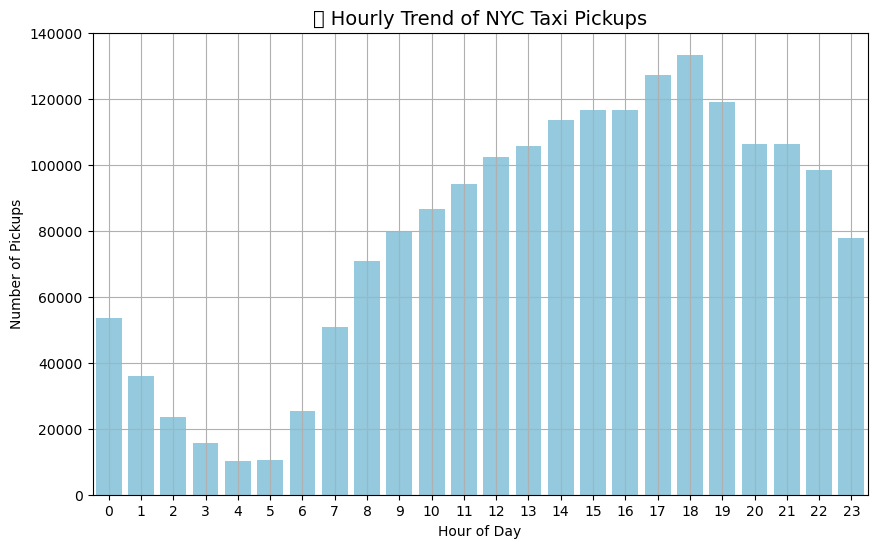

In [37]:
# Find and show the hourly trends in taxi pickups

# Extract day name
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day_name()
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour 
df['quarter'] = df['tpep_pickup_datetime'].dt.to_period('Q').astype(str)
df['trip_duration_mins'] = round((df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60).astype(int)  #Trip duration in mins


plt.figure(figsize=(10, 6))
sns.countplot(x='pickup_hour', data=df, color='skyblue')
plt.title("📈 Hourly Trend of NYC Taxi Pickups", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Pickups")
plt.grid(True)
plt.show()


/tmp/ipykernel_50355/1729137112.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_counts.index, y=day_counts.values, palette="viridis")


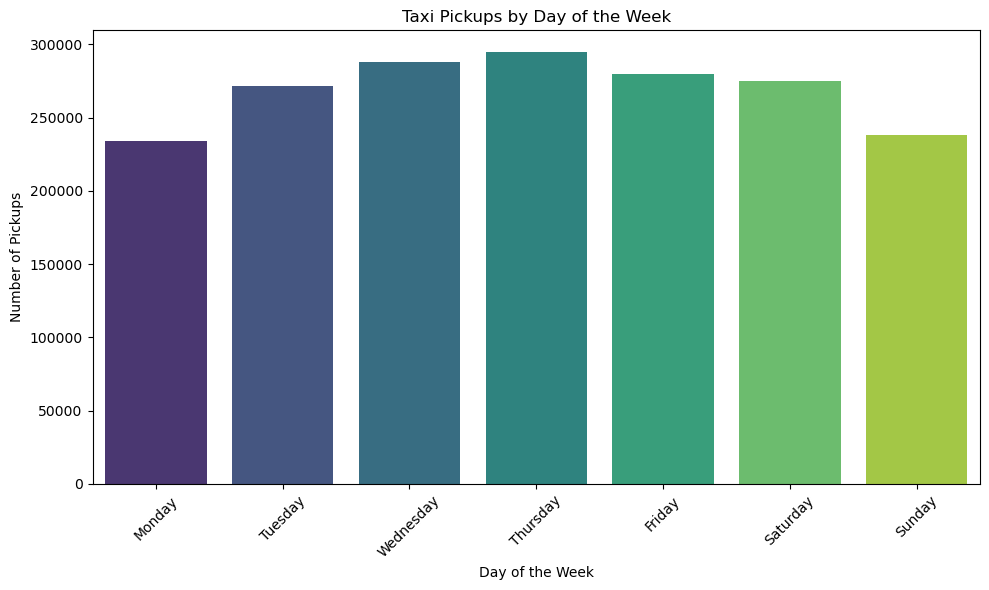

In [38]:
# Find and show the daily trends in taxi pickups (days of the week)
df['day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()
day_counts = df['day_of_week'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.figure(figsize=(10, 6))
sns.barplot(x=day_counts.index, y=day_counts.values, palette="viridis")
plt.title("Taxi Pickups by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Pickups")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_50355/828446956.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette='magma')


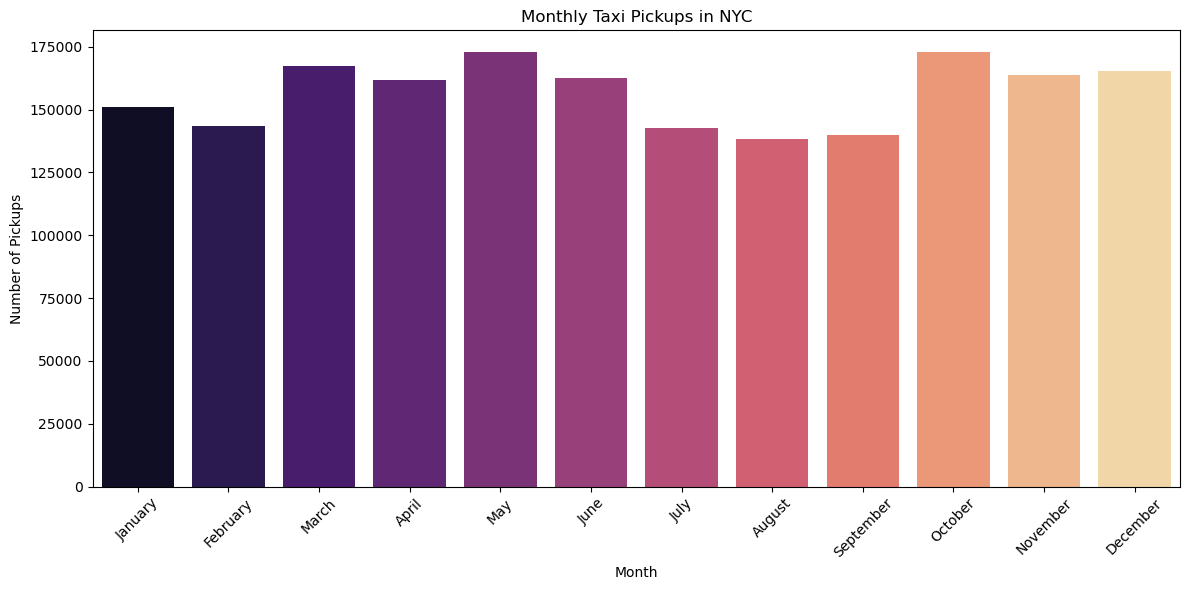

In [39]:
# Show the monthly trends in pickups
# Extract month number and name
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month
df['month_name'] = df['tpep_pickup_datetime'].dt.month_name()
monthly_counts = df['month_name'].value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette='magma')
plt.title("Monthly Taxi Pickups in NYC")
plt.xlabel("Month")
plt.ylabel("Number of Pickups")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [40]:
# Analyse the above parameters
for col in ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']:
    zero_records = df[df[col] == 0].shape[0]
    negative_records = df[df[col] < 0].shape[0]
    print(f"{col} — \nZeros: {zero_records}", f"Negatives: {negative_records}")

fare_amount — 
Zeros: 47 Negatives: 0
tip_amount — 
Zeros: 423989 Negatives: 0
total_amount — 
Zeros: 0 Negatives: 0
trip_distance — 
Zeros: 34765 Negatives: 0


Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [41]:
# Create a df with non zero entries for the selected parameters.

cols_to_check = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']
for col in cols_to_check:
    zero_neg = df[df[col] <= 0]
    print(f"{col}: {len(zero_neg)} records with <= 0")

df_clean = df[(
    (df['fare_amount'] > 0) &
    (df['tip_amount'] >= 0) &
    (df['total_amount'] > 0) &
    (df['trip_distance'] > 0)
 )].copy()
print("Original size: ", df.shape[0])
print("Result: ", df.shape)

fare_amount: 47 records with <= 0
tip_amount: 423989 records with <= 0
total_amount: 0 records with <= 0
trip_distance: 34765 records with <= 0
Original size:  1882369
Result:  (1882369, 27)


In [42]:
df=df_clean.copy()

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

In [43]:
# Create a df with non zero entries for the selected parameters.
# Step 1: Keep rows with valid trip_distance (> 0)
df_non_zero = df[df['trip_distance'] > 0]

# Step 2: Add back trips where distance is 0 but pickup & dropoff zones are the same (likely very short trips)
same_zone_zero_dist = df[(df['trip_distance'] == 0) & (df['PULocationID'] == df['DOLocationID'])]
df_non_zero = pd.concat([df_non_zero, same_zone_zero_dist], ignore_index=True)

# Step 3: Remove rows where fare_amount or total_amount is zero (invalid transactions)
df_non_zero = df_non_zero[df_non_zero['fare_amount'] > 0]
df_non_zero = df_non_zero[df_non_zero['total_amount'] > 0]

# Summary
print("Original dataset size:", df.shape[0])
print("Filtered dataset size:", df_non_zero.shape[0])
# Group data by month and analyse monthly revenue
monthly_revenue = df_non_zero.groupby('pickup_month')['total_amount'].sum().reset_index()

# Rename columns for clarity
monthly_revenue.columns = ['Month', 'Total_Revenue']

# Sort months in case they are out of order
monthly_revenue = monthly_revenue.sort_values('Month')

Original dataset size: 1847604
Filtered dataset size: 1847604


In [44]:
plt.figure(figsize=(8, 4))
sns.lineplot(x='pickup_month', y='total_amount', data=monthly_revenue, marker='o', color='teal')
plt.title("Monthly Revenue from NYC Taxi Rides")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `pickup_month` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x400 with 0 Axes>

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [45]:
# Create a df with non zero entries for the selected parameters.
# Step 1: Keep rows with valid trip_distance (> 0)

df_non_zero = df[df['trip_distance'] > 0]

# Step 2: Add back trips where distance is 0 but pickup & dropoff zones are the same (likely very short trips)
same_zone_zero_dist = df[(df['trip_distance'] == 0) & (df['PULocationID'] == df['DOLocationID'])]
df_non_zero = pd.concat([df_non_zero, same_zone_zero_dist], ignore_index=True)

# Step 3: Remove rows where fare_amount or total_amount is zero (invalid transactions)
df_non_zero = df_non_zero[df_non_zero['fare_amount'] > 0]
df_non_zero = df_non_zero[df_non_zero['total_amount'] > 0]

# Step 2: Calculate total revenue per quarter
quarterly_revenue = df.groupby('quarter')['total_amount'].sum().sort_index()
# Summary
print("Original size:", df.shape[0])
print("Filtered non-zero set:", df_non_zero.shape[0])

Original size: 1847604
Filtered non-zero set: 1847604


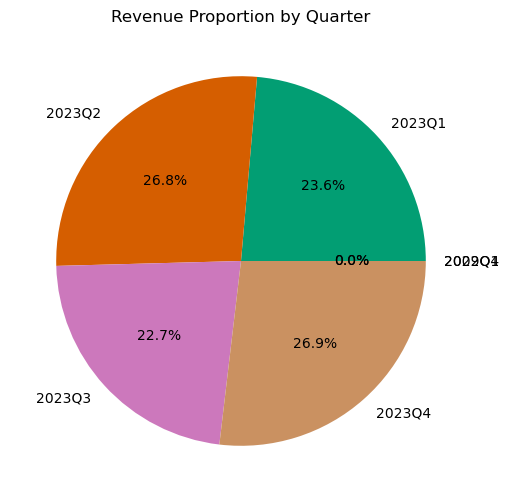

In [46]:
plt.figure(figsize=(6, 6))
plt.pie(quarterly_revenue, labels=quarterly_revenue.index, 
        autopct='%1.1f%%', colors=sns.color_palette('colorblind'))
plt.title('Revenue Proportion by Quarter')
plt.show()

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

               trip_distance  fare_amount
trip_distance       1.000000     0.944339
fare_amount         0.944339     1.000000 
 near to one shows trip_distance is proportional to fare_amount


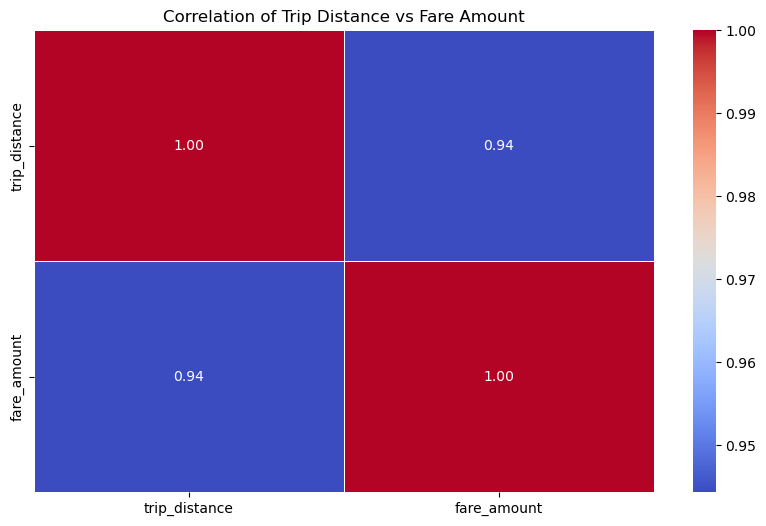

Correlation between trip_distance and fare_amount: 0.9443


In [48]:
# Show how trip fare is affected by distance
corr_dist_fare = df[['trip_distance', 'fare_amount']].corr()
print(corr_dist_fare,"\n near to one shows trip_distance is proportional to fare_amount")

plt.figure(figsize=(10, 6))
sns.heatmap(corr_dist_fare, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation of Trip Distance vs Fare Amount')
plt.show()

# Correlation
correlation = df_non_zero['trip_distance'].corr(df_non_zero['fare_amount'])
print(f"Correlation between trip_distance and fare_amount: {correlation:.4f}")


In [49]:
print("Correlation: Fare vs Trip Duration:", df[['fare_amount', 'trip_duration_mins']].corr().iloc[0, 1])
print("Correlation: Fare vs Passenger Count:", df[['fare_amount', 'passenger_count']].corr().iloc[0, 1])
print("Correlation: Tip vs Trip Distance:", df[['tip_amount', 'trip_distance']].corr().iloc[0, 1])

Correlation: Fare vs Trip Duration: 0.2768708068484596
Correlation: Fare vs Passenger Count: 0.04355228600588363
Correlation: Tip vs Trip Distance: 0.6127582804465267


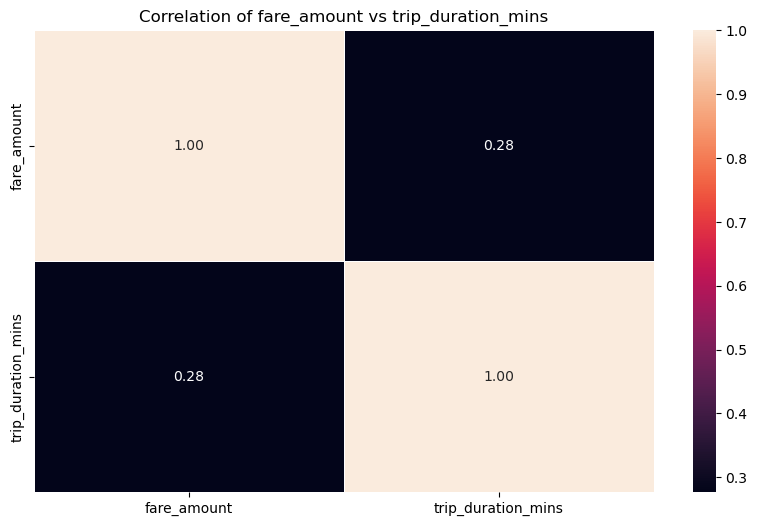

Correlation between fare_amount and trip_duration_mins: 0.2769


In [50]:
# Show relationship between fare and trip duration
corr_duration_fare = df_non_zero[['fare_amount','trip_duration_mins']].corr()

plt.figure(figsize = (10, 6))
sns.heatmap(data = corr_duration_fare, cmap = 'rocket', fmt = '.2f', linewidths = 0.5, annot = True)
plt.title('Correlation of fare_amount vs trip_duration_mins')
plt.show()

#Correlation
corr_1 = df_non_zero['fare_amount'].corr(df_non_zero['trip_duration_mins'])
print(f"Correlation between fare_amount and trip_duration_mins: {corr_1:.4f}")

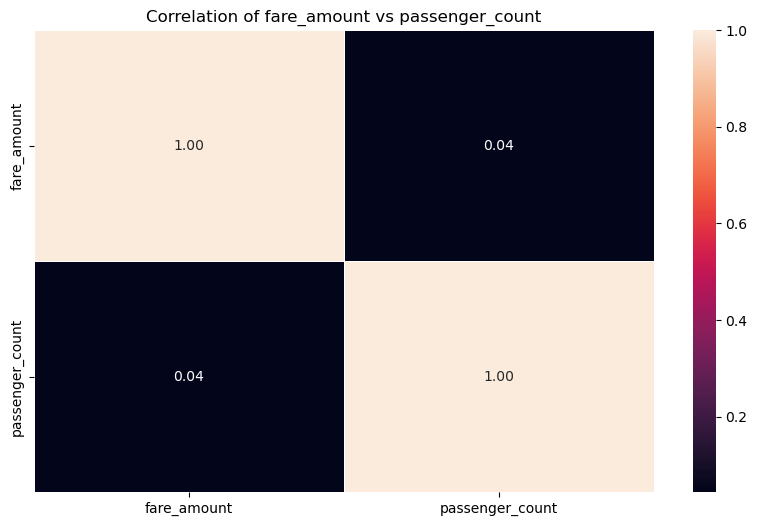

Correlation between fare_amount and passenger_count: 0.0436


In [52]:
# Show relationship between fare and number of passengers
corr_fare_passenger = df_non_zero[['fare_amount','passenger_count']].corr()
plt.figure(figsize = (10, 6))
sns.heatmap(data = corr_fare_passenger, cmap = 'rocket', fmt = '.2f', linewidths = 0.5, annot = True)
plt.title('Correlation of fare_amount vs passenger_count')
plt.show()

#Correlation
corr_2 = df_non_zero['fare_amount'].corr(df_non_zero['passenger_count'])
print(f"Correlation between fare_amount and passenger_count: {corr_2:.4f}")

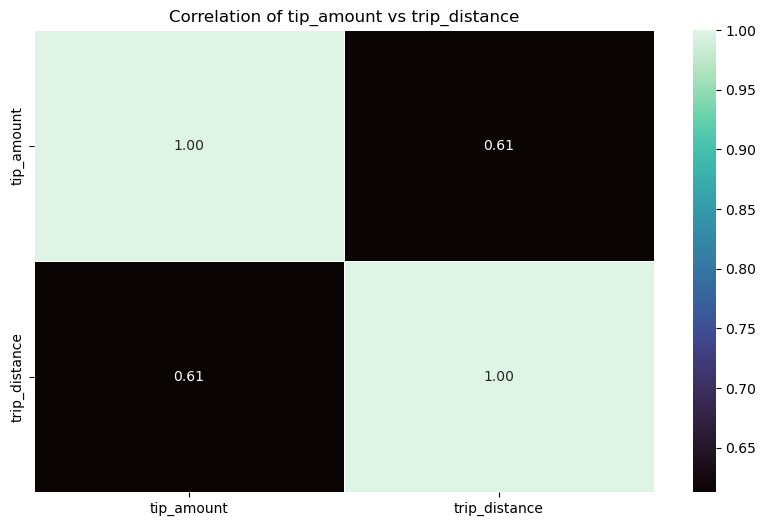

Correlation between tip_amount and trip_distance: 0.6128


In [53]:
# Show relationship between tip and trip distance
corr_tip_dist = df_non_zero[['tip_amount','trip_distance']].corr()
plt.figure(figsize = (10, 6))
sns.heatmap(data = corr_tip_dist, cmap = 'mako', fmt = '.2f', linewidths = 0.5, annot = True)
plt.title('Correlation of tip_amount vs trip_distance')
plt.show()
#Correlation
corr_3 = df_non_zero['tip_amount'].corr(df_non_zero['trip_distance'])
print(f"Correlation between tip_amount and trip_distance: {corr_3:.4f}")

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

In [54]:
df_non_zero.payment_type.value_counts()

payment_type
1    1468593
2     310236
0      49643
4      12336
3       6796
Name: count, dtype: int64

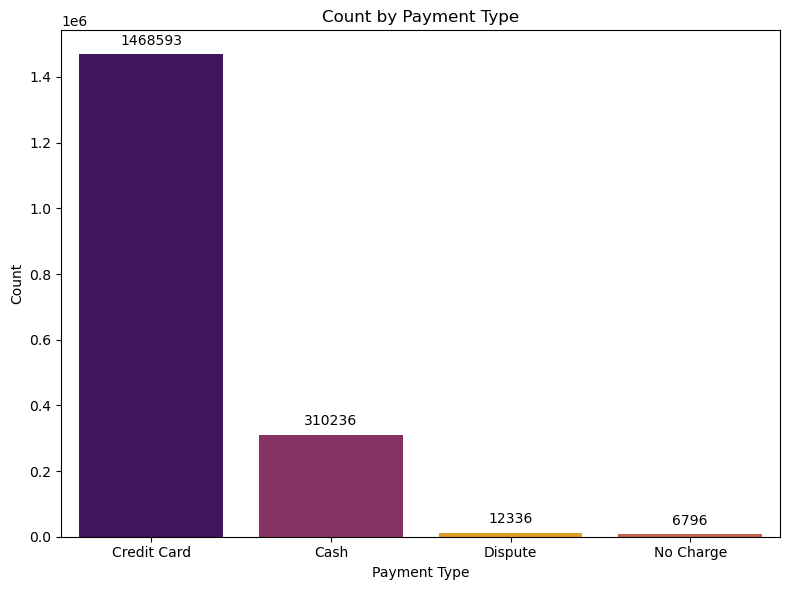

payment_type_labelled
Credit Card    1468593
Cash            310236
Dispute          12336
No Charge         6796
Name: count, dtype: int64


In [55]:
# Analyse the distribution of different payment types (payment_type).

# Analyse the distribution of different payment types (payment_type).
# Map payment_type codes to readable labels
payment_mapping = {
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute',
}

# Apply the mapping
df_non_zero['payment_type_labelled'] = df_non_zero['payment_type'].map(payment_mapping)

# Plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_non_zero, x='payment_type_labelled', hue='payment_type_labelled', palette='inferno', legend=False,
                   order=df_non_zero['payment_type_labelled'].value_counts().index)

plt.title('Count by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Count')

# Add integer labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5)

plt.xticks
plt.tight_layout()
plt.show()

#Print value counts
print(df_non_zero['payment_type_labelled'].value_counts())


- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [56]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable


**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [57]:
import geopandas as gpd


# Read the shapefile using geopandas
zones = gpd.read_file("/home/rv/upgrad/nyc_taxi/Datasets and Dictionary/taxi_zones/taxi_zones.shp")
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

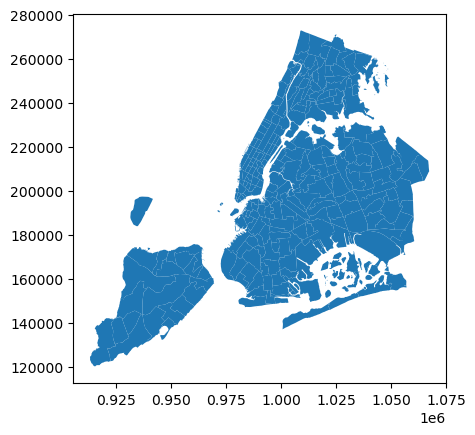

In [58]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [59]:
# Merge zones and trip records using locationID and PULocationID
merged_df = df_non_zero.merge(zones, how='left', left_on='PULocationID', right_on='LocationID')
# unmatched location IDs after merge
unmatched_pickups = merged_df[merged_df['LocationID'].isna()]['PULocationID'].value_counts()
# Display the result
print(unmatched_pickups)


PULocationID
264    16163
265      718
57         4
Name: count, dtype: int64


**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

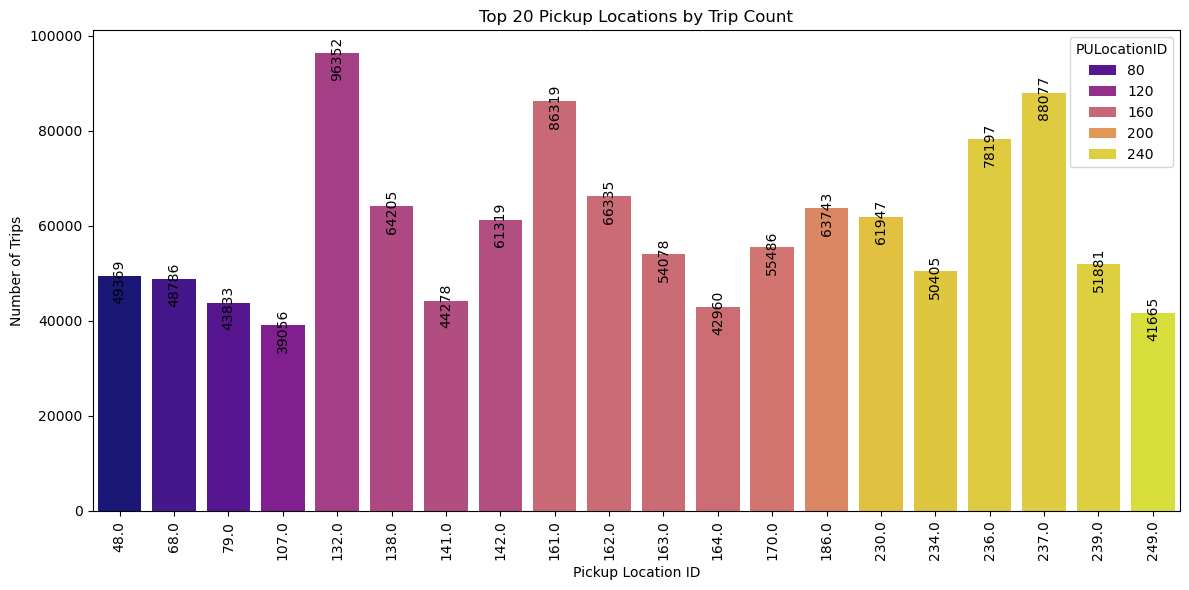

LocationID
132.0    96352
237.0    88077
161.0    86319
236.0    78197
162.0    66335
138.0    64205
186.0    63743
230.0    61947
142.0    61319
170.0    55486
163.0    54078
239.0    51881
234.0    50405
48.0     49369
68.0     48786
141.0    44278
79.0     43833
164.0    42960
249.0    41665
107.0    39056
Name: count, dtype: int64


In [60]:
# Group data by location and calculate the number of trips
pickup_counts = merged_df['LocationID'].value_counts().nlargest(20)
top_pickup_ids = pickup_counts.index

# Filter the merged DataFrame to include only the top pickup zones
top_pickup_df = merged_df[merged_df['LocationID'].isin(top_pickup_ids)]

# Plot the count of trips for top pickup locations
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=top_pickup_df, x='LocationID', hue='PULocationID', palette='plasma')
plt.title('Top 20 Pickup Locations by Trip Count')
plt.xlabel('Pickup Location ID')
plt.ylabel('Number of Trips')
plt.xticks(rotation=90)

# Add bar labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=-20, rotation=90)

plt.tight_layout()
plt.show()

# Display the top pickup location counts
print(pickup_counts)


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [61]:
# Merge trip counts back to the zones GeoDataFrame
trip_counts = merged_df['LocationID'].value_counts().reset_index()
trip_counts.columns = ['LocationID', 'ride_count']
merged_zones = pd.merge(zones, trip_counts, on='LocationID', how='left')
# Display the first few rows to verify the merge
merged_zones.head()



OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...   

   ride_count  
0        50.0  
1         3.0  
2         5.0  
3      2139.0  
4         NaN

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

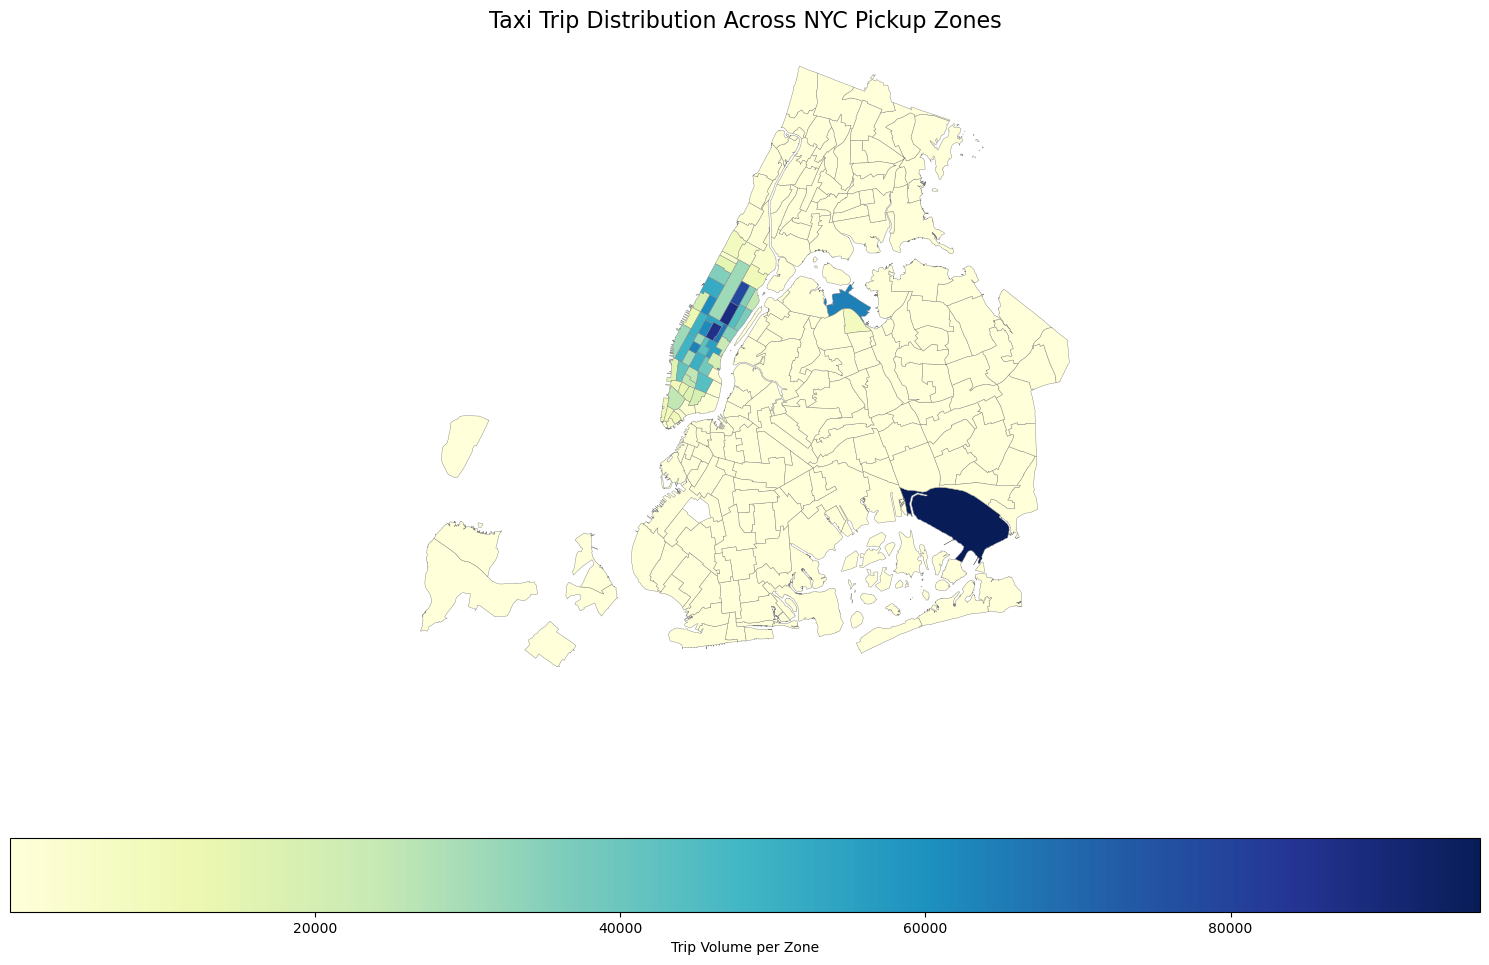

In [62]:
# Define figure and axis
fig, axis = plt.subplots(figsize=(15, 10))
# Plot the map and display it
merged_zones.plot(
    ax=axis,
    column='ride_count',
    cmap='YlGnBu',
    legend=True,
    legend_kwds={
        'label': "Trip Volume per Zone",
        'orientation': 'horizontal'
    },
    edgecolor='gray',
    linewidth=0.3
)

# Add a descriptive title and clean up the plot
axis.set_title('Taxi Trip Distribution Across NYC Pickup Zones', fontsize=16)
axis.set_axis_off()

# Render the map
plt.tight_layout()
plt.show()

In [63]:
# can you try displaying the zones DF sorted by the number of trips?
merged_zones.sort_values(by='ride_count', ascending=False).head(20)


OBJECTID  Shape_Leng  Shape_Area                          zone  \
131       132    0.245479    0.002038                   JFK Airport   
236       237    0.042213    0.000096         Upper East Side South   
160       161    0.035804    0.000072                Midtown Center   
235       236    0.044252    0.000103         Upper East Side North   
161       162    0.035270    0.000048                  Midtown East   
137       138    0.107467    0.000537             LaGuardia Airport   
185       186    0.024696    0.000037  Penn Station/Madison Sq West   
229       230    0.031028    0.000056     Times Sq/Theatre District   
141       142    0.038176    0.000076           Lincoln Square East   
169       170    0.045769    0.000074                   Murray Hill   
162       163    0.034177    0.000041                 Midtown North   
238       239    0.063626    0.000205         Upper West Side South   
233       234    0.036072    0.000073                      Union Sq   
47         48    0.043747    0.000094                  Clinton East   
67         68    0.049337    0.000111                  East Chelsea   
140       141    0.041514    0.000077               Lenox Hill West   
78         79    0.042625    0.000108                  East Village   
163       164    0.035772    0.000056                 Midtown South   
248       249    0.036384    0.000072                  West Village   
106       107    0.038041    0.000075                      Gramercy   

     LocationID    borough                                           geometry  \
131         132     Queens  MULTIPOLYGON (((1032791.001 181085.006, 103283...   
236         237  Manhattan  POLYGON ((993633.442 216961.016, 993507.232 21...   
160         161  Manhattan  POLYGON ((991081.026 214453.698, 990952.644 21...   
235         236  Manhattan  POLYGON ((995940.048 221122.92, 995812.322 220...   
161         162  Manhattan  POLYGON ((992224.354 214415.293, 992096.999 21...   
137         138     Queens  MULTIPOLYGON (((1019904.219 225677.983, 102031...   
185         186  Manhattan  POLYGON ((986752.603 210853.699, 986627.863 21...   
229         230  Manhattan  POLYGON ((988786.877 214532.094, 988650.277 21...   
141         142  Manhattan  POLYGON ((989380.305 218980.247, 989359.803 21...   
169         170  Manhattan  POLYGON ((991999.299 210994.739, 991972.635 21...   
162         163  Manhattan  POLYGON ((989412.663 219020.943, 990045.841 21...   
238         239  Manhattan  POLYGON ((991168.979 226252.992, 991955.565 22...   
233         234  Manhattan  POLYGON ((987029.847 207022.299, 987048.27 206...   
47           48  Manhattan  POLYGON ((986694.313 214463.846, 986568.184 21...   
67           68  Manhattan  POLYGON ((983690.405 209040.369, 983550.612 20...   
140         141  Manhattan  POLYGON ((994839.073 216123.698, 994786.74 216...   
78           79  Manhattan  POLYGON ((988746.067 202151.955, 988733.885 20...   
163         164  Manhattan  POLYGON ((988787.425 210315.593, 988662.868 21...   
248         249  Manhattan  POLYGON ((983555.319 204876.901, 983469.158 20...   
106         107  Manhattan  POLYGON ((989131.643 205749.904, 989084.531 20...   

     ride_count  
131     96352.0  
236     88077.0  
160     86319.0  
235     78197.0  
161     66335.0  
137     64205.0  
185     63743.0  
229     61947.0  
141     61319.0  
169     55486.0  
162     54078.0  
238     51881.0  
233     50405.0  
47      49369.0  
67      48786.0  
140     44278.0  
78      43833.0  
163     42960.0  
248     41665.0  
106     39056.0

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [64]:
# Find routes which have the slowest speeds at different times of the day

speed_df = df_non_zero.copy()

# Remove entries with zero or negative distance or duration
speed_df = speed_df[(speed_df['trip_duration_mins'] > 0) & (speed_df['trip_distance'] > 0)]

# Compute speed for each trip (miles per hour)
speed_df['mph'] = (speed_df['trip_distance'] / speed_df['trip_duration_mins']) * 60

# Group data by pickup/dropoff zones and hour
route_hourly = speed_df.groupby(['PULocationID', 'DOLocationID', 'pickup_hour']).agg({
    'trip_distance': 'mean',
    'trip_duration_mins': 'mean'
}).reset_index()

# Calculate average speed per route per hour
route_hourly['average_mph'] = (route_hourly['trip_distance'] / route_hourly['trip_duration_mins']) * 60

# Sort to find the slowest 3 routes for each hour
slowest_by_hour = route_hourly.sort_values(by='average_mph').groupby('pickup_hour').head(3)

# Output the results
print(slowest_by_hour)

        PULocationID  DOLocationID  pickup_hour  trip_distance  \
88508            207           132           12       0.010000   
88521            207           226           12       0.010000   
115057           246           180           21       0.120000   
120702           261           264           11       0.040000   
3555              14           172            2       0.220000   
...              ...           ...          ...            ...   
96025            230            41            7       3.950000   
14181             50           164            8       1.798571   
3755              24            24            6       0.010000   
120431           261           232           11       2.088889   
94876            229           161            6       0.936538   

        trip_duration_mins  average_mph  
88508          1521.000000     0.000394  
88521          1427.000000     0.000420  
115057         1199.000000     0.006005  
120702          330.000000     0.007273

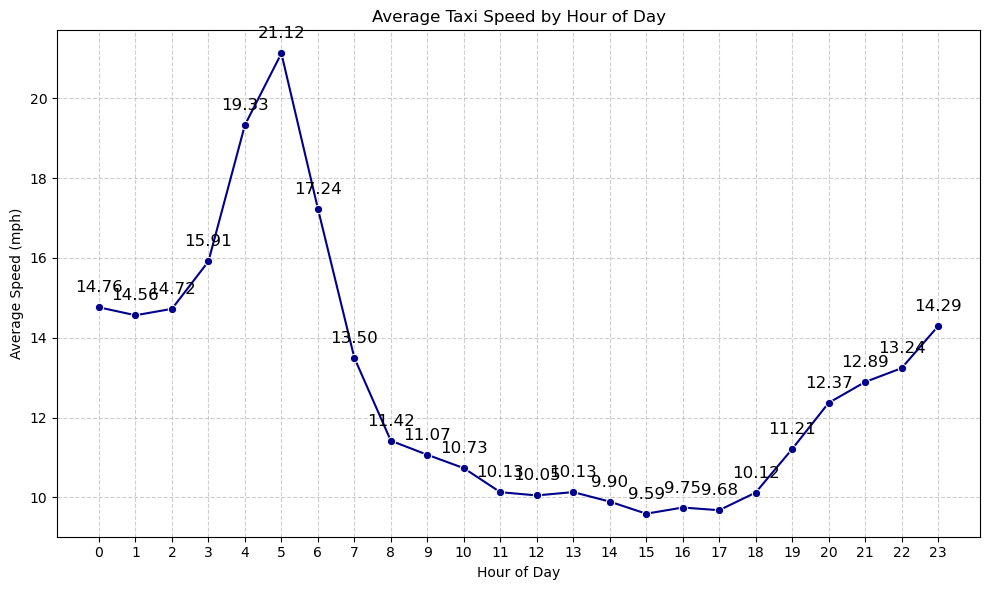

In [65]:
# Plot mean speed by hour using a line plot
plt.figure(figsize=(10, 6))

# Calculate average speed per hour
hourly_speed = speed_df.groupby('pickup_hour')['mph'].mean().reset_index()

sns.lineplot(
    data=hourly_speed,
    x='pickup_hour',
    y='mph',
    marker='o',
    color='darkblue'
)

for x, y in zip(hourly_speed['pickup_hour'], hourly_speed['mph']):
    plt.text(x, y + 0.3, f"{y:.2f}", ha='center', va='bottom', fontsize=12)

plt.xlabel('Hour of Day')
plt.ylabel('Average Speed (mph)')
plt.title('Average Taxi Speed by Hour of Day')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

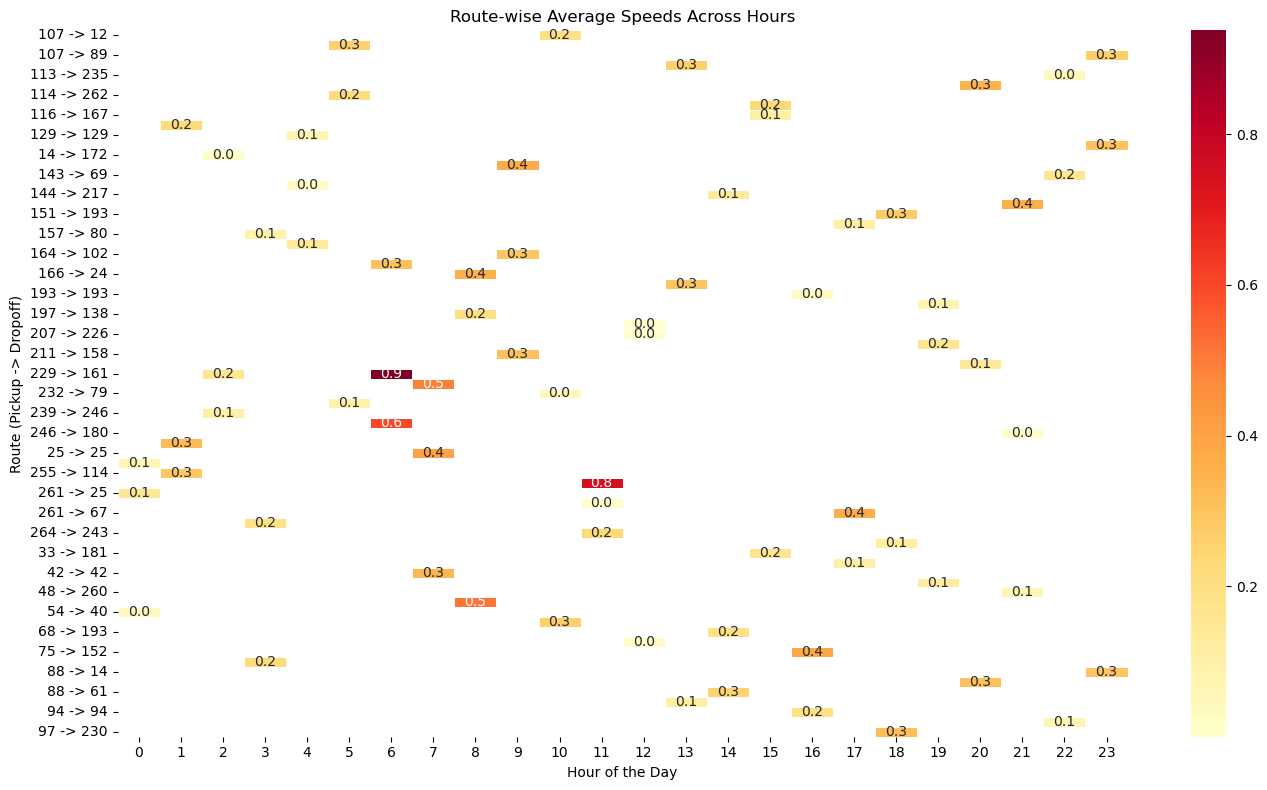

In [66]:
# Create a descriptive route label combining pickup and dropoff IDs
slowest_by_hour['route_label'] = slowest_by_hour['PULocationID'].astype(str) + " -> " + slowest_by_hour['DOLocationID'].astype(str)

# Reshape the data to format routes as rows and hours as columns for heatmap
heatmap_matrix = slowest_by_hour.pivot(index='route_label', columns='pickup_hour', values='average_mph')

# Plotting the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_matrix,
    annot=True,
    fmt=".1f",
    cmap='YlOrRd',
    linewidths=0.5
)
plt.title('Route-wise Average Speeds Across Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Route (Pickup -> Dropoff)')
plt.tight_layout()
plt.show()

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

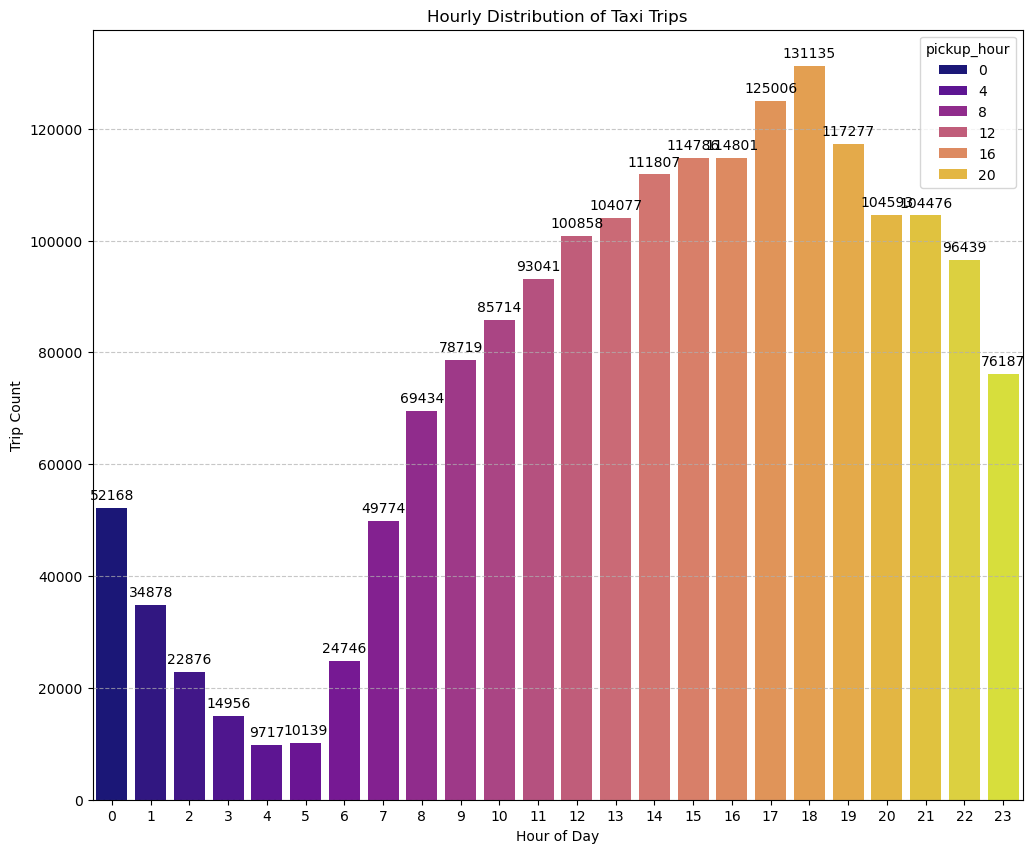

Peak activity occurs at 18:00 with 131,135 trips.


In [67]:
# Visualise the number of trips per hour and find the busiest hour
trips_per_hour = df_non_zero['pickup_hour'].value_counts().sort_index()

# Plotting trip counts by hour
plt.figure(figsize=(12, 10))
chart = sns.barplot(
    x=trips_per_hour.index,
    y=trips_per_hour.values,
    palette='plasma',
    hue=trips_per_hour.index
)

plt.title('Hourly Distribution of Taxi Trips')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Count')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label bars with trip counts
for bar_container in chart.containers:
    chart.bar_label(bar_container, fmt='%d', padding=4)

plt.show()

# Find and print the hour with the highest number of trips
peak_hour = trips_per_hour.idxmax()
peak_count = trips_per_hour.max()

print(f"Peak activity occurs at {peak_hour}:00 with {peak_count:,} trips.")

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [68]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
reference_size = 5000  

# Calculate sampling fraction based on new reference
sample_fraction = len(df_non_zero) / reference_size

# Count trips by hour in the sample data
hourly_counts = df_non_zero['pickup_hour'].value_counts()

# Select the top 5 hours with the highest trip counts
top_5_hours = hourly_counts.nlargest(5)

# Scale the counts to estimate actual trip volumes
estimated_counts = (top_5_hours * sample_fraction).round().astype(int)

# Display the results
print("Top 5 Hours by Trip Count (Sample Data):")
print(top_5_hours.sort_values(ascending=False))

print("\nEstimated Total Trips (Scaled):")
print(estimated_counts.sort_values(ascending=False))


Top 5 Hours by Trip Count (Sample Data):
pickup_hour
18    131135
17    125006
19    117277
16    114801
15    114786
Name: count, dtype: int64

Estimated Total Trips (Scaled):
pickup_hour
18    48457110
17    46192317
19    43336291
16    42421357
15    42415815
Name: count, dtype: int64


**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

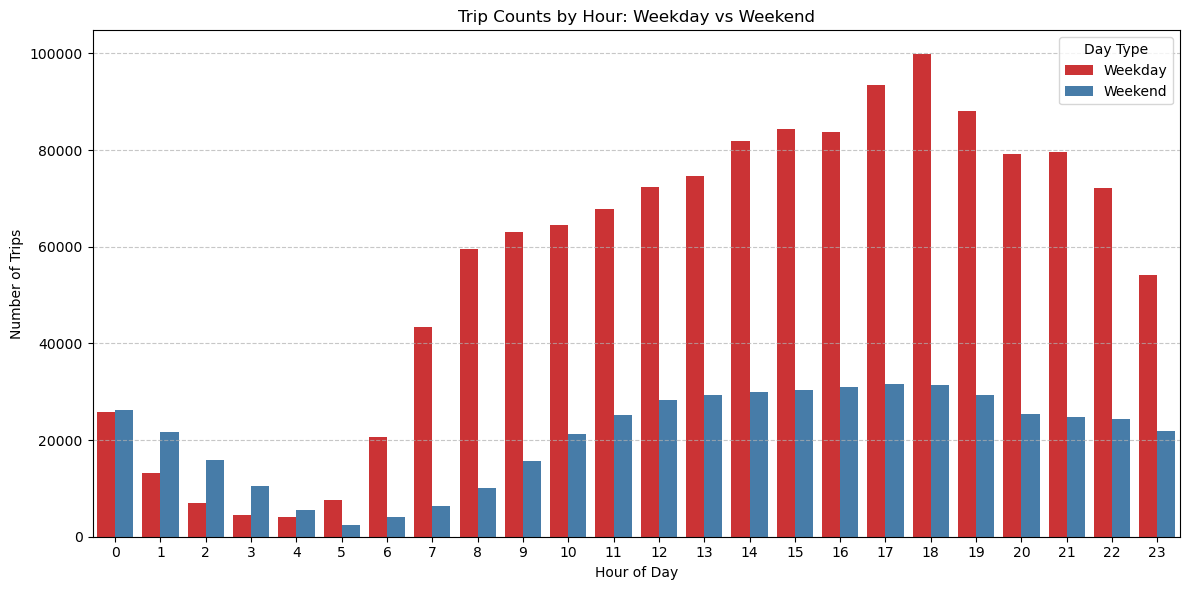

In [69]:
# Compare traffic trends for the week days and weekends
# Classify day type
df_non_zero['day_type'] = df_non_zero['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_non_zero, 
    x='pickup_hour', 
    hue='day_type', 
    palette='Set1'
)
plt.title('Trip Counts by Hour: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.legend(title='Day Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [70]:
# Find top 10 pickup and dropoff zones

# Identify top 10 pickup locations by trip count
top_pu_zones = df_non_zero['PULocationID'].value_counts().nlargest(10).index
df_top_pickups = df_non_zero[df_non_zero['PULocationID'].isin(top_pu_zones)]

# Aggregate pickup trips by location and pickup_hour
pickup_hourly_counts = (
    df_top_pickups
    .groupby(['PULocationID', 'pickup_hour'])
    .size()
    .reset_index(name='trip_count')
)

# Identify top 10 dropoff locations by trip count
top_do_zones = df_non_zero['DOLocationID'].value_counts().nlargest(10).index
df_top_dropoffs = df_non_zero[df_non_zero['DOLocationID'].isin(top_do_zones)]

# Aggregate dropoff trips by location and pickup_hour
dropoff_hourly_counts = (
    df_top_dropoffs
    .groupby(['DOLocationID', 'pickup_hour'])
    .size()
    .reset_index(name='trip_count')
)


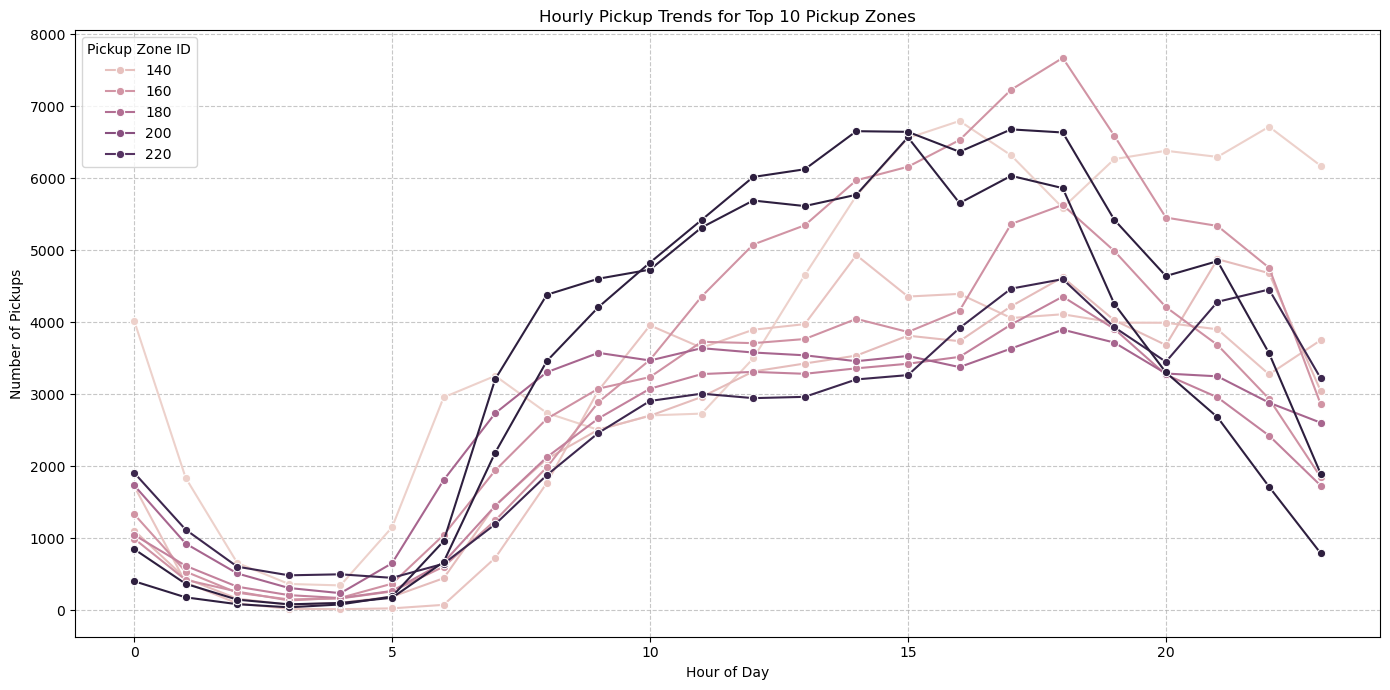

In [71]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
plt.figure(figsize=(14, 7))

sns.lineplot(
    data=pickup_hourly_counts, 
    x='pickup_hour', 
    y='trip_count', 
    hue='PULocationID', 
    marker='o'
)

plt.title('Hourly Pickup Trends for Top 10 Pickup Zones')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Pickup Zone ID')
plt.tight_layout()
plt.show()


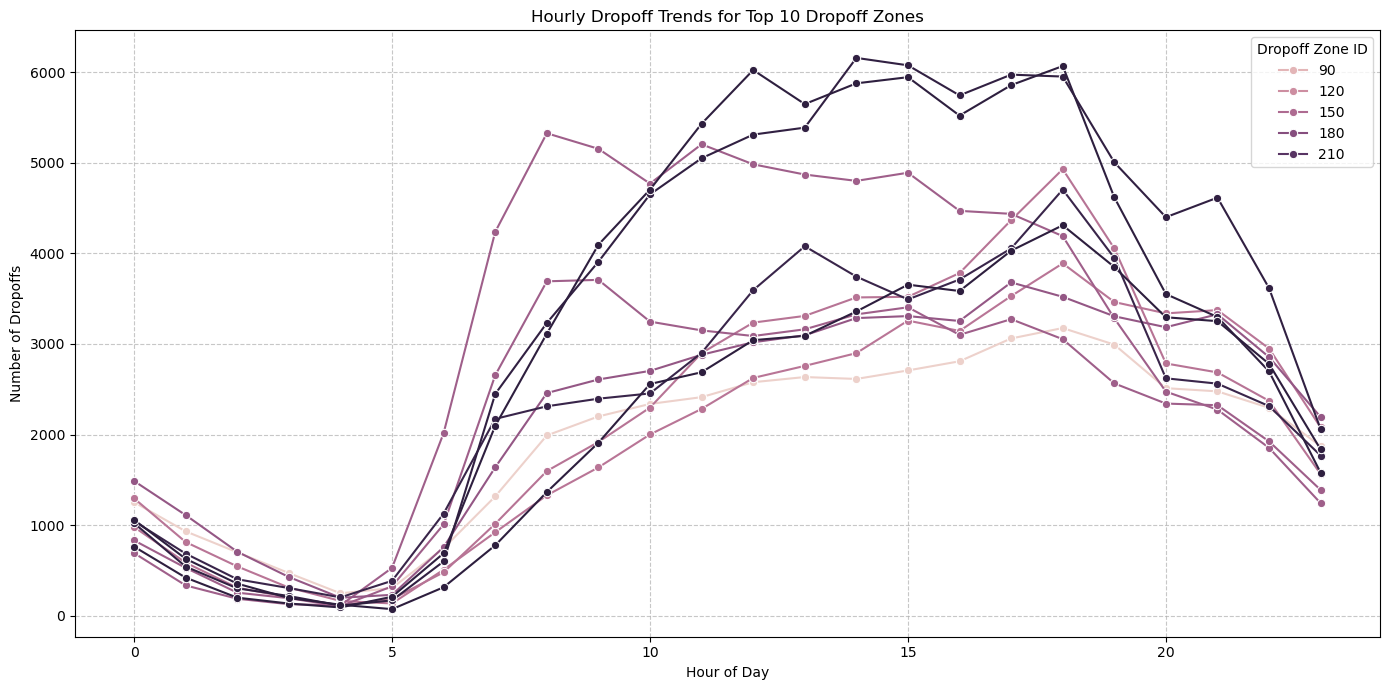

In [72]:
plt.figure(figsize=(14, 7))

sns.lineplot(
    data=dropoff_hourly_counts, 
    x='pickup_hour', 
    y='trip_count', 
    hue='DOLocationID', 
    marker='o'
)

plt.title('Hourly Dropoff Trends for Top 10 Dropoff Zones')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Dropoffs')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Dropoff Zone ID')
plt.tight_layout()
plt.show()

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [73]:
# Count pickups and dropoffs per zone
pickup_counts = df['PULocationID'].value_counts().rename('pickup_count')
dropoff_counts = df['DOLocationID'].value_counts().rename('dropoff_count')

# Combine counts into one DataFrame, filling missing values with zero
zone_counts = pd.concat([pickup_counts, dropoff_counts], axis=1).fillna(0)

# Calculate pickup-to-dropoff ratio; avoid division errors
zone_counts['pickup_drop_ratio'] = zone_counts['pickup_count'] / zone_counts['dropoff_count'].replace(0, np.nan)

# Drop zones where ratio cannot be calculated
zone_counts = zone_counts.dropna(subset=['pickup_drop_ratio'])

# Join with zone metadata for names
zone_counts = zone_counts.merge(
    zones[['LocationID', 'zone']], 
    left_index=True, right_on='LocationID', how='left'
)

# Get top and bottom 10 zones by ratio
top_10 = zone_counts.sort_values(by='pickup_drop_ratio', ascending=False).head(10)
bottom_10 = zone_counts.sort_values(by='pickup_drop_ratio').head(10)

# Display results
print("Top 10 Pickup/Dropoff Ratio Zones:")
print(top_10[['zone', 'pickup_count', 'dropoff_count', 'pickup_drop_ratio']])

print("\nBottom 10 Pickup/Dropoff Ratio Zones:")
print(bottom_10[['zone', 'pickup_count', 'dropoff_count', 'pickup_drop_ratio']])


Top 10 Pickup/Dropoff Ratio Zones:
                                   zone  pickup_count  dropoff_count  \
69.0                      East Elmhurst        8274.0          939.0   
131.0                       JFK Airport       96352.0        21563.0   
137.0                 LaGuardia Airport       64205.0        24010.0   
185.0      Penn Station/Madison Sq West       63743.0        40395.0   
1.0                         Jamaica Bay           3.0            2.0   
113.0           Greenwich Village South       24945.0        17862.0   
42.0                       Central Park       31174.0        22696.0   
248.0                      West Village       41665.0        30939.0   
206.0  Saint Michaels Cemetery/Woodside          32.0           24.0   
161.0                      Midtown East       66335.0        52648.0   

       pickup_drop_ratio  
69.0            8.811502  
131.0           4.468395  
137.0           2.674094  
185.0           1.577992  
1.0             1.500000  
113.0     

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [74]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

# Define night hours range
night_hours = [23, 0, 1, 2, 3, 4, 5]

# Filter trips during night hours
night_df = speed_df[speed_df['pickup_hour'].isin(night_hours)]

# Show count of records for night trips
print(f"Number of night hour trips: {night_df.shape[0]}")

# Get top 10 pickup zones at night
top_night_pickups = night_df['PULocationID'].value_counts().nlargest(10)
print("Top 10 Nighttime Pickup Zones:\n", top_night_pickups)

# Get top 10 dropoff zones at night
top_night_dropoffs = night_df['DOLocationID'].value_counts().nlargest(10)
print("Top 10 Nighttime Dropoff Zones:\n", top_night_dropoffs)

# Total pickups during night hours
total_night_pickups = night_df.shape[0]
print(f"Total pickups during night hours: {total_night_pickups}")


Number of night hour trips: 220283
Top 10 Nighttime Pickup Zones:
 PULocationID
79     15768
132    14486
249    12881
48     10384
148    10055
114     8987
230     8297
186     6981
68      6353
164     6313
Name: count, dtype: int64
Top 10 Nighttime Dropoff Zones:
 DOLocationID
79     8389
48     7005
170    6344
68     5772
107    5727
263    5340
141    5331
249    5136
230    4774
229    4427
Name: count, dtype: int64
Total pickups during night hours: 220283


In [75]:
# Merge pickup zone names
night_df = night_df.merge(
    zones[['LocationID', 'zone']],
    how='left',
    left_on='PULocationID',
    right_on='LocationID'
).rename(columns={'zone': 'PU_Zone'}).drop(columns='LocationID')

# Merge dropoff zone names
night_df = night_df.merge(
    zones[['LocationID', 'zone']],
    how='left',
    left_on='DOLocationID',
    right_on='LocationID'
).rename(columns={'zone': 'DO_Zone'}).drop(columns='LocationID')

# Get top 10 pickup and dropoff zones by name
top_pu_zones = night_df['PU_Zone'].value_counts().head(10)
top_do_zones = night_df['DO_Zone'].value_counts().head(10)

# Filter the dataset to include only top zones
pickup_data = night_df[night_df['PU_Zone'].isin(top_pu_zones.index)]
dropoff_data = night_df[night_df['DO_Zone'].isin(top_do_zones.index)]

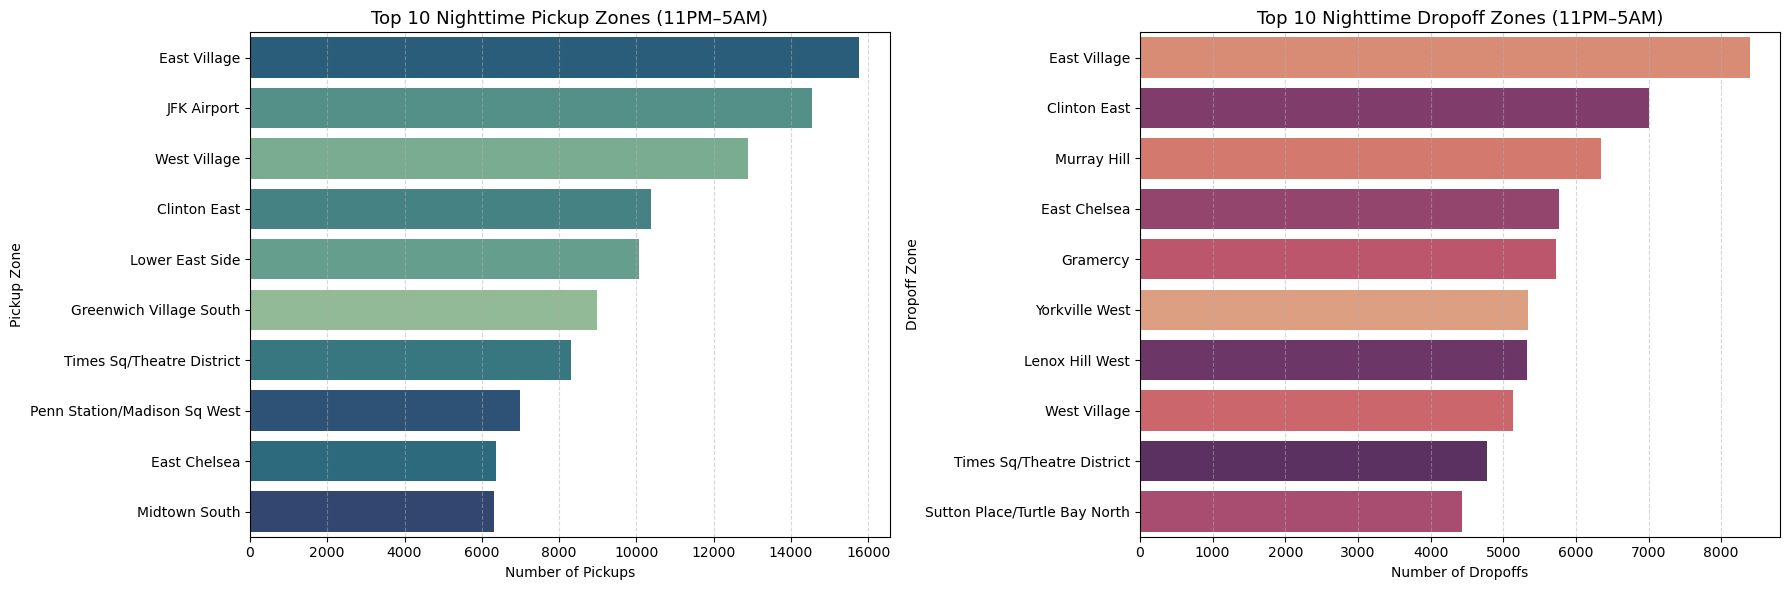

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=False)

# Pickup Zones Plot
sns.countplot(
    data=pickup_data,
    y='PU_Zone',
    order=top_pu_zones.index,
    palette='crest',
    hue='PU_Zone',
    legend=False,
    ax=axes[0]
)
axes[0].set_title('Top 10 Nighttime Pickup Zones (11PM–5AM)', fontsize=13)
axes[0].set_xlabel('Number of Pickups')
axes[0].set_ylabel('Pickup Zone')
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

# Dropoff Zones Plot
sns.countplot(
    data=dropoff_data,
    y='DO_Zone',
    order=top_do_zones.index,
    palette='flare',
    hue='DO_Zone',
    legend=False,
    ax=axes[1]
)
axes[1].set_title('Top 10 Nighttime Dropoff Zones (11PM–5AM)', fontsize=13)
axes[1].set_xlabel('Number of Dropoffs')
axes[1].set_ylabel('Dropoff Zone')
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [77]:
# Filter for night hours (11 PM to 5 AM)
# Define time intervals
night_hours = [23, 0, 1, 2, 3, 4, 5]
day_hours = list(set(range(24)) - set(night_hours))

# Separate day and night revenue
night_revenue = speed_df[speed_df['pickup_hour'].isin(night_hours)]['total_amount'].sum()
day_revenue = speed_df[speed_df['pickup_hour'].isin(day_hours)]['total_amount'].sum()
total_revenue = night_revenue + day_revenue

# Calculate percentage share
night_pct = (night_revenue / total_revenue) * 100
day_pct = (day_revenue / total_revenue) * 100

# Output results
print(f"Nighttime Revenue: ${night_revenue:,.2f} ({night_pct:.2f}%)")
print(f"Daytime Revenue: ${day_revenue:,.2f} ({day_pct:.2f}%)")


Nighttime Revenue: $6,477,128.12 (12.17%)
Daytime Revenue: $46,765,844.40 (87.83%)


/tmp/ipykernel_50355/2376204629.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=revenue_df, x='Time of Day', y='Revenue (%)', palette=['purple', 'gold'])


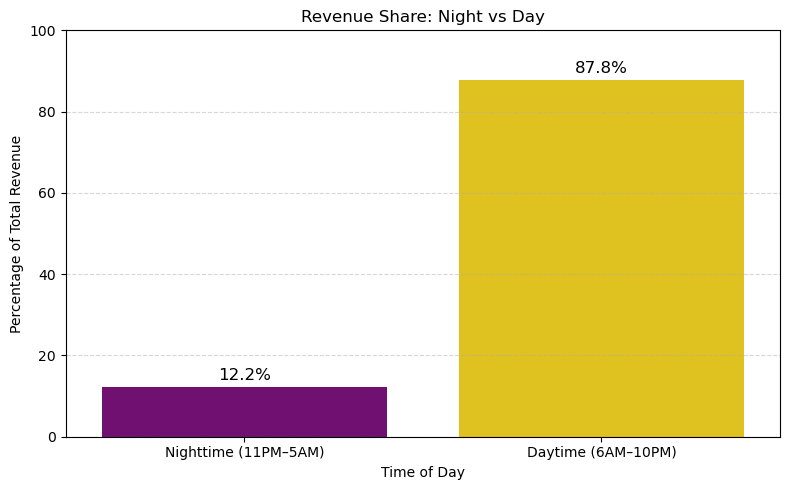

In [78]:
# Bar chart: Revenue share comparison
import seaborn as sns

# Create a simple DataFrame for plotting
revenue_df = pd.DataFrame({
    'Time of Day': ['Nighttime (11PM–5AM)', 'Daytime (6AM–10PM)'],
    'Revenue (%)': [night_pct, day_pct]
})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=revenue_df, x='Time of Day', y='Revenue (%)', palette=['purple', 'gold'])
plt.title('Revenue Share: Night vs Day')
plt.ylabel('Percentage of Total Revenue')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add text labels
for i, value in enumerate(revenue_df['Revenue (%)']):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [79]:
# Analyse the fare per mile per passenger for different passenger counts
# Filter data to exclude trips with zero or invalid distances and passenger counts
filtered_df = speed_df[(speed_df['trip_distance'] > 0) & (speed_df['passenger_count'] > 0)]

# Compute fare per mile for each trip
filtered_df['fare_per_mile'] = filtered_df['fare_amount'] / filtered_df['trip_distance']

# Calculate fare per mile divided by number of passengers to get per-passenger fare efficiency
filtered_df['fare_per_mile_per_passenger'] = filtered_df['fare_per_mile'] / filtered_df['passenger_count']

# Aggregate by passenger count to find the average fare per mile per passenger
average_fare = filtered_df.groupby('passenger_count')['fare_per_mile_per_passenger'].mean().reset_index()

# Show the summarized statistics
print(average_fare)




   passenger_count  fare_per_mile_per_passenger
0              1.0                     8.498605
1              2.0                     4.333234
2              3.0                     2.914416
3              4.0                     2.212681
4              5.0                     1.572129
5              6.0                     1.343036


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

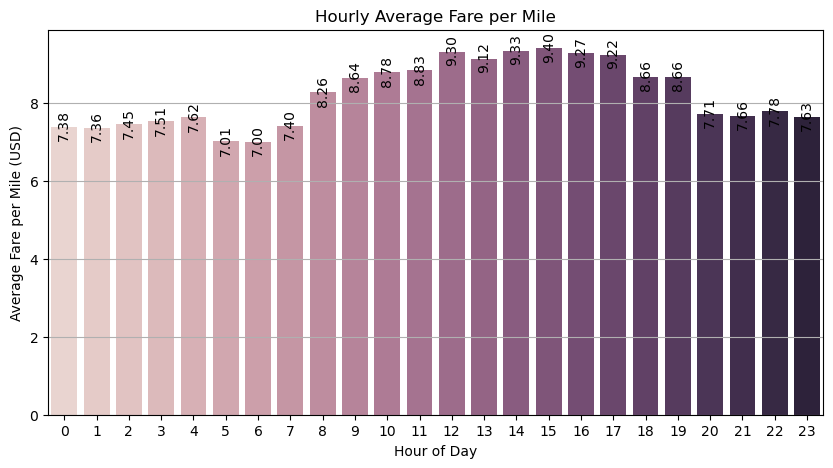

In [80]:
# Compare the average fare per mile for different days and for different times of the day
avg_fare_hourly = filtered_df.groupby('pickup_hour')['fare_per_mile'].mean().reset_index()

# Visualize the hourly variation in average fare per mile
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=avg_fare_hourly, x='pickup_hour', y='fare_per_mile', hue='pickup_hour', legend=False)

# Add value labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=-10, rotation=90)

plt.title('Hourly Average Fare per Mile')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare per Mile (USD)')
plt.grid(axis='y')
plt.show()


**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

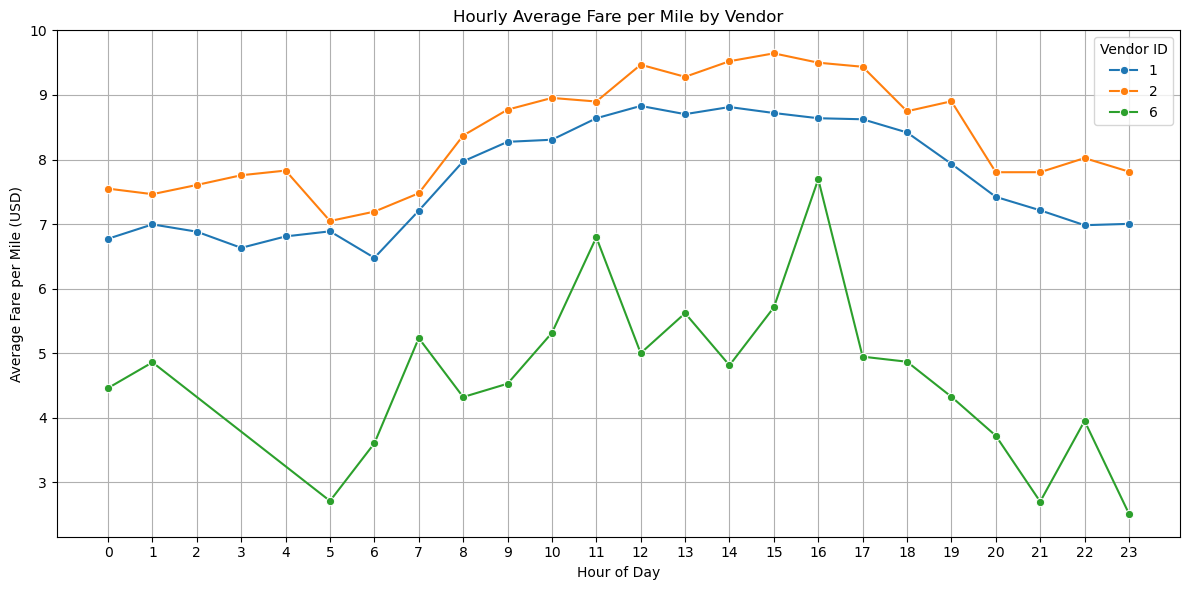

In [81]:
# Compare fare per mile for different vendors
# Make sure pickup datetime and hour columns are properly set
filtered_df['tpep_pickup_datetime'] = pd.to_datetime(filtered_df['tpep_pickup_datetime'], errors='coolwarm')
filtered_df['pickup_hour'] = filtered_df['tpep_pickup_datetime'].dt.hour

# Calculate mean fare per mile grouped by vendor and hour
fare_by_vendor_hour = filtered_df.groupby(['VendorID', 'pickup_hour'])['fare_per_mile'].mean().reset_index()

# Plot hourly average fare per mile for each vendor using a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=fare_by_vendor_hour, x='pickup_hour', y='fare_per_mile', hue='VendorID', marker='o', palette='tab10')
plt.title('Hourly Average Fare per Mile by Vendor')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare per Mile (USD)')
plt.xticks(range(24))
plt.grid(True)
plt.legend(title='Vendor ID')
plt.tight_layout()
plt.show()



**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


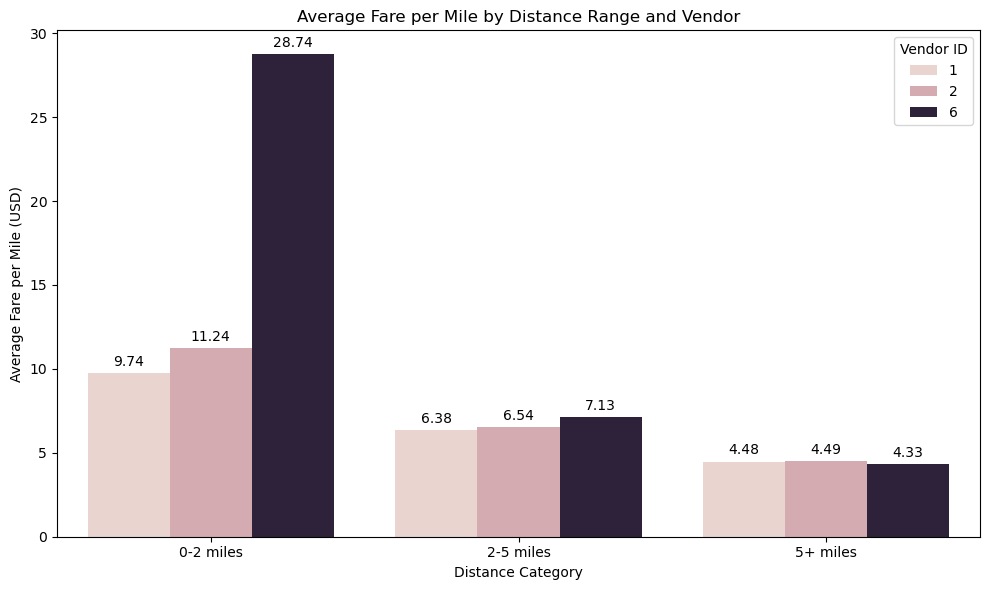

In [85]:
# Defining distance tiers

# Function to assign distance categories
def assign_distance_tier(distance):
    if distance <= 2:
        return '0-2 miles'
    elif distance <= 5:
        return '2-5 miles'
    return '5+ miles'

# Apply the categorization to the trip_distance column
filtered_df['distance_category'] = filtered_df['trip_distance'].apply(assign_distance_tier)

# Calculate the mean fare per mile for each VendorID and distance category
avg_fare_by_tier = (
    filtered_df
    .groupby(['VendorID', 'distance_category'])['fare_per_mile']
    .mean()
    .reset_index()
)

# Create bar plot to visualize the results
plt.figure(figsize=(10, 6))
plot = sns.barplot(
    data=avg_fare_by_tier,
    x='distance_category',
    y='fare_per_mile',
    hue='VendorID',
)

# Add labels to each bar
for bars in plot.containers:
    plot.bar_label(bars, fmt='%.2f', padding=3)

# Configure plot aesthetics
plt.title('Average Fare per Mile by Distance Range and Vendor')
plt.xlabel('Distance Category')
plt.ylabel('Average Fare per Mile (USD)')
plt.legend(title='Vendor ID')
plt.tight_layout()
plt.show()


##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

/tmp/ipykernel_50355/3535953855.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('distance_group')['tip_percentage']


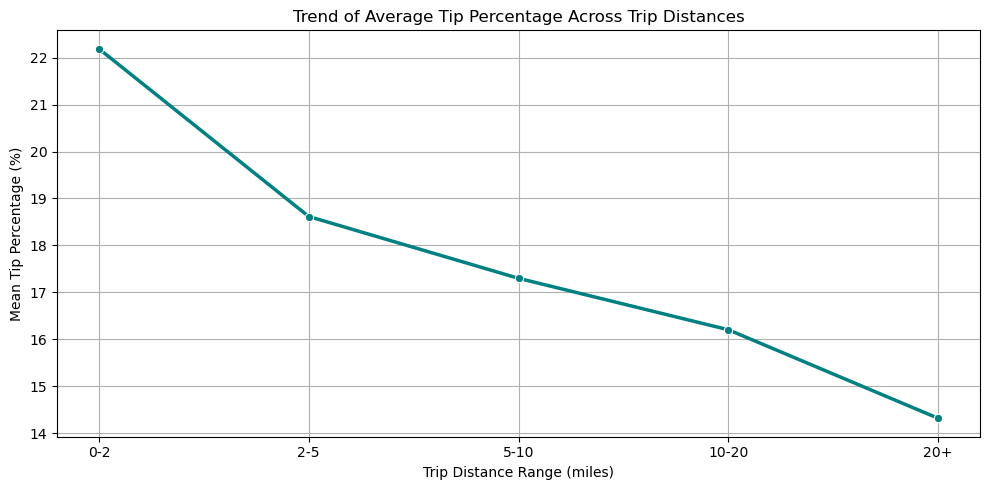

In [87]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
# Calculate tip as a percentage of fare
filtered_df['tip_percentage'] = (filtered_df['tip_amount'] / filtered_df['fare_amount']) * 100

# Define custom bins for trip distance
distance_breaks = [0, 2, 5, 10, 20, filtered_df['trip_distance'].max()]
distance_ranges = ['0-2', '2-5', '5-10', '10-20', '20+']
filtered_df['distance_group'] = pd.cut(filtered_df['trip_distance'], bins=distance_breaks, labels=distance_ranges)

# Calculate the average tip percentage for each distance group
tip_summary = (
    filtered_df
    .groupby('distance_group')['tip_percentage']
    .mean()
    .reset_index()
)

# Plot the average tip percentage by distance group as a line plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=tip_summary, x='distance_group', y='tip_percentage', marker='o', linewidth=2.5, color='teal')
plt.title('Trend of Average Tip Percentage Across Trip Distances')
plt.xlabel('Trip Distance Range (miles)')
plt.ylabel('Mean Tip Percentage (%)')
plt.grid(True)
plt.tight_layout()
plt.show()



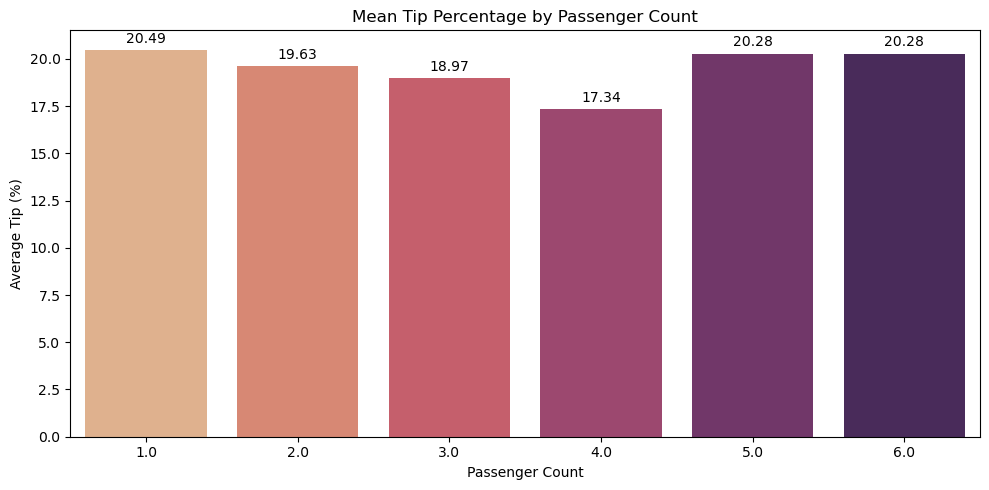

In [93]:
# Analyze Tip % by Passenger Count
tip_by_passenger_count = (
    filtered_df
    .groupby('passenger_count')['tip_percentage']
    .mean()
    .reset_index()
)

# Set up the bar plot
plt.figure(figsize=(10, 5))
bar = sns.barplot(
    data=tip_by_passenger_count,
    x='passenger_count',
    y='tip_percentage',
    palette='flare',
    hue='passenger_count',
    dodge=False,
    legend=False
)

# Add value labels on each bar
for bars in bar.containers:
    bar.bar_label(bars, fmt='%.2f', padding=3)

# Customize plot appearance
plt.title('Mean Tip Percentage by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Average Tip (%)')
plt.tight_layout()
plt.show()


Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

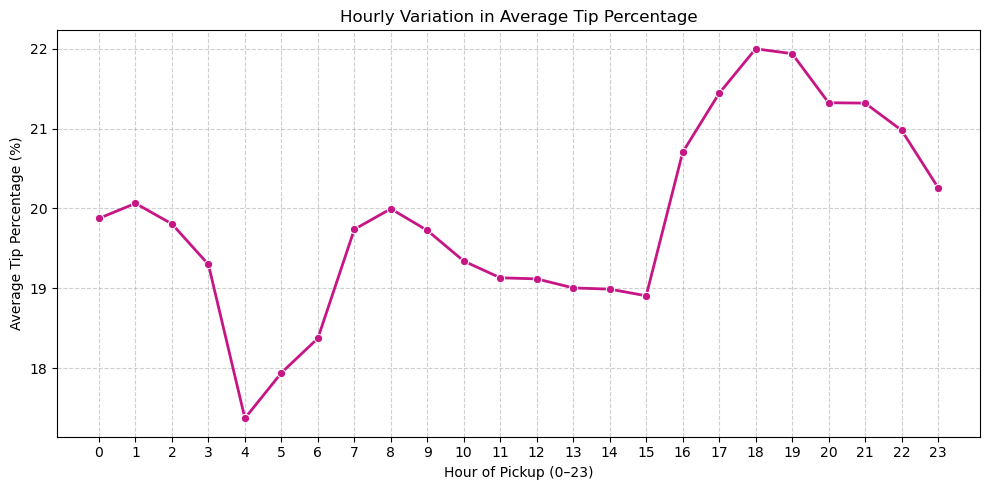

In [96]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

# Determine average tip percentage for each hour of the day
hourly_tip_trends = (
    filtered_df
    .groupby('pickup_hour')['tip_percentage']
    .mean()
    .reset_index()
)

# Create a line chart to visualize tip trends by hour
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=hourly_tip_trends,
    x='pickup_hour',
    y='tip_percentage',
    marker='o',
    linewidth=2,
    color='mediumvioletred'
)

# Customize the plot
plt.title('Hourly Variation in Average Tip Percentage')
plt.xlabel('Hour of Pickup (0–23)')
plt.ylabel('Average Tip Percentage (%)')
plt.xticks(range(0, 24))
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

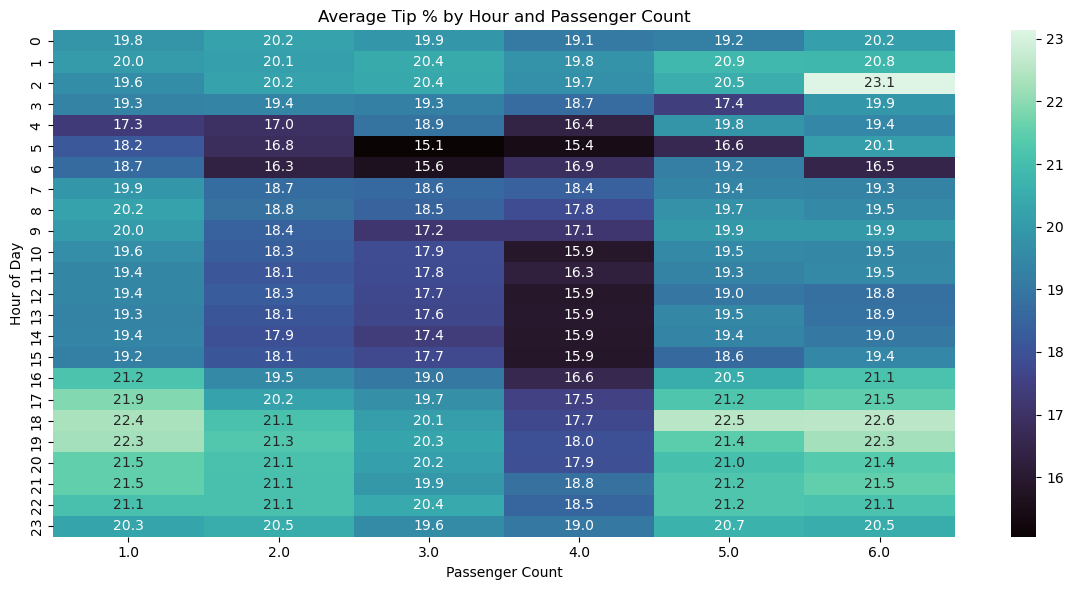

In [100]:
# Compute mean tip % by hour and passenger count
tip_heatmap_data = filtered_df.groupby(['pickup_hour', 'passenger_count'])['tip_percentage'].mean().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(tip_heatmap_data, annot=True, fmt='.1f', cmap='mako')
plt.title('Average Tip % by Hour and Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()


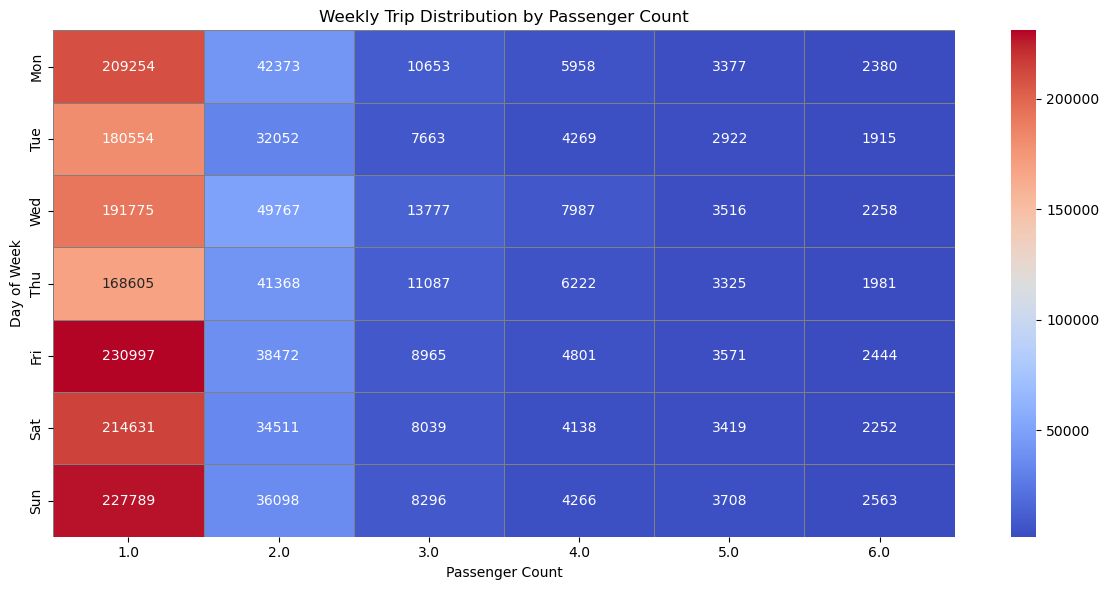

In [106]:
# Summarize trip volume by weekday and passenger count
trips_by_day_passenger = (
    filtered_df
    .groupby(['pickup_day', 'passenger_count'])
    .size()
    .unstack(fill_value=0)
)

# Replace numerical day indices with weekday names for readability
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
trips_by_day_passenger.index = weekday_labels

# Plot heatmap showing trip frequency by weekday and passenger group size
plt.figure(figsize=(12, 6))
sns.heatmap(
    trips_by_day_passenger,
    annot=True,
    fmt='d',
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Weekly Trip Distribution by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()


**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

Total records for top 50 pickup zones: 1795552


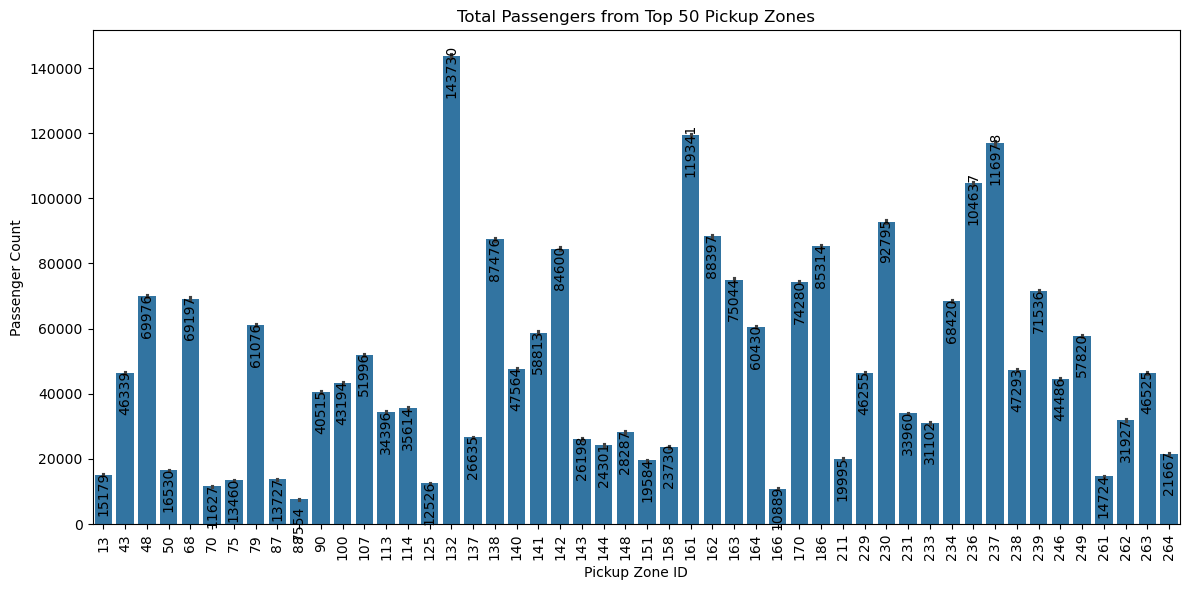

In [115]:
# How does passenger count vary across zones
# Calculate total passenger count per pickup zone and select top 50
top_pickup_zones = (
    speed_df.groupby('PULocationID')['passenger_count']
    .sum()
    .nlargest(50)
    .index
)

# Filter data to include only trips from these top zones
df_top_zones = speed_df[speed_df['PULocationID'].isin(top_pickup_zones)]

# Display number of trips from top pickup zones
print("Total records for top 50 pickup zones:", df_top_zones.shape[0])

# Visualize total passenger count for top pickup zones
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_top_zones,
    x='PULocationID',
    y='passenger_count',
    estimator='sum',
)

# Annotate bars with exact values
ax.bar_label(ax.containers[0], fmt='%d', padding=-30, rotation=90)

# Set plot labels and title
ax.set_title('Total Passengers from Top 50 Pickup Zones')
ax.set_xlabel('Pickup Zone ID')
ax.set_ylabel('Passenger Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

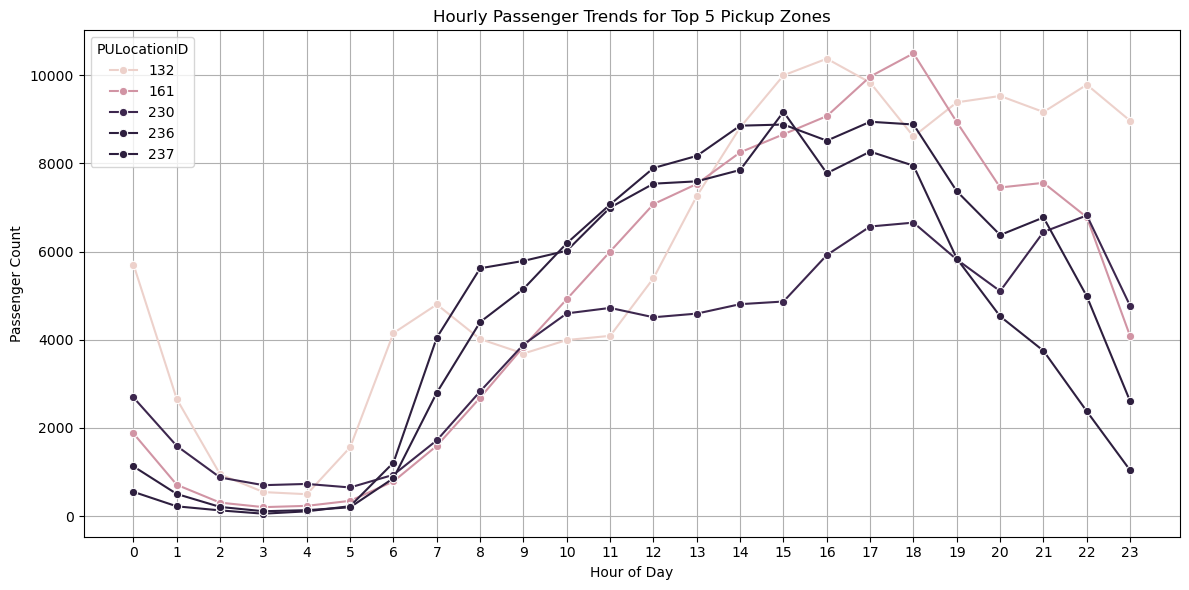

In [119]:
top_zones = df_top_zones.groupby('PULocationID')['passenger_count'].sum().nlargest(5).index

# Filter data
df_top5 = df_top_zones[df_top_zones['PULocationID'].isin(top_zones)]

# Group by hour and zone
hourly_trends = df_top5.groupby(['pickup_hour', 'PULocationID'])['passenger_count'].sum().reset_index()

# Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_trends, x='pickup_hour', y='passenger_count', hue='PULocationID', marker='o')
plt.title('Hourly Passenger Trends for Top 5 Pickup Zones')
plt.xlabel('Hour of Day')
plt.ylabel('Passenger Count')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

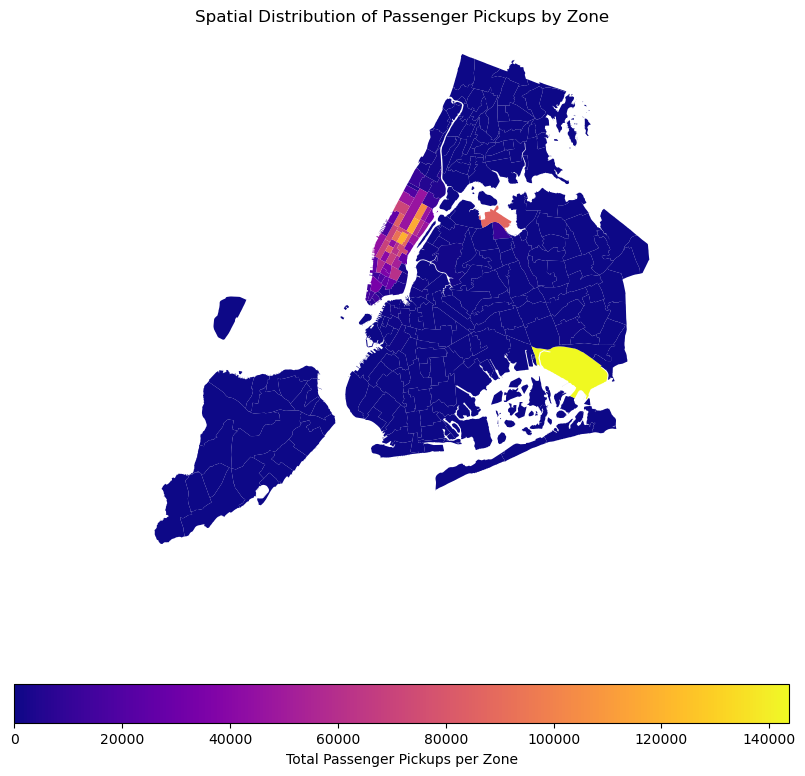

In [124]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

# Create a working copy of the merged zones GeoDataFrame
zones_geo = merged_zones.copy()

# Initialize passenger count columns for pickups and dropoffs
zones_geo['PU_passenger_count'] = 0
zones_geo['DO_passenger_count'] = 0

# Calculate total pickups and dropoffs per zone
pickup_totals = speed_df.groupby('PULocationID')['passenger_count'].sum()
dropoff_totals = speed_df.groupby('DOLocationID')['passenger_count'].sum()

# Map totals back to the GeoDataFrame using LocationID
zones_geo['PU_passenger_count'] = zones_geo['LocationID'].map(pickup_totals).fillna(0)
zones_geo['DO_passenger_count'] = zones_geo['LocationID'].map(dropoff_totals).fillna(0)

# Plot pickup volumes by zone
fig, ax = plt.subplots(figsize=(10, 10))
zones_geo.plot(
    ax=ax,
    column='PU_passenger_count',
    cmap='plasma',
    legend=True,
    legend_kwds={'label': 'Total Passenger Pickups per Zone', 'orientation': 'horizontal'}
)
plt.title('Spatial Distribution of Passenger Pickups by Zone')
plt.axis('off')
plt.show()


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [125]:
# How often is each surcharge applied?

print("🔸 Distribution of 'extra' charges (e.g., night or peak hour surcharges):")
print(speed_df['extra'].value_counts())

print("\n🔹 MTA Tax (Metropolitan Transportation Authority) distribution:")
print(speed_df['mta_tax'].value_counts())

print("\n🔸 Congestion surcharge distribution (typically applies in Manhattan during peak hours):")
print(speed_df['congestion_surcharge'].value_counts())

print("\n🔹 Improvement surcharge distribution (flat fee added to all trips):")
print(speed_df['improvement_surcharge'].value_counts())

🔸 Distribution of 'extra' charges (e.g., night or peak hour surcharges):
extra
0.00     718700
2.50     459412
1.00     359944
5.00     133190
3.50     106275
7.50      16084
6.00      15819
4.25       6240
9.25       6230
1.75       3214
3.75       2425
6.75       2388
8.75       2148
2.75       2124
10.25      1630
7.75       1378
1.25       1338
11.75      1277
2.25        853
6.25        783
9.75        573
10.00       552
7.25        473
11.25       418
8.50        341
3.20         43
3.00         29
5.25         26
0.50         26
4.75         14
3.25          7
2.72          5
2.45          4
3.05          3
0.70          3
1.50          3
4.50          2
14.25         2
11.00         2
0.02          2
12.75         2
7.00          2
0.75          2
0.25          1
5.50          1
8.25          1
2.80          1
6.80          1
1.70          1
1.12          1
0.03          1
0.05          1
2.00          1
12.50         1
8.20          1
Name: count, dtype: int64

🔹 MTA Tax (Met

In [129]:
# Loop through each zone (LocationID from 1 to 263) to calculate total 'extra' surcharges for pickups and dropoffs
for zone_id in range(1, 264):
    # Filter records for this pickup and dropoff zone
    pickup_data = speed_df[speed_df['PULocationID'] == zone_id]
    dropoff_data = speed_df[speed_df['DOLocationID'] == zone_id]

    # Calculate the total extra surcharge for pickups and dropoffs
    pickup_extra_total = pickup_data['extra'].sum()
    dropoff_extra_total = dropoff_data['extra'].sum()

    # Assign calculated values to the appropriate rows in the GeoDataFrame
    merged_zones.loc[merged_zones['LocationID'] == zone_id, 'pickup_extra'] = pickup_extra_total
    merged_zones.loc[merged_zones['LocationID'] == zone_id, 'dropoff_extra'] = dropoff_extra_total

# Fill any missing values (zones with no trips) with 0
merged_zones['pickup_extra'].fillna(0)
merged_zones['dropoff_extra'].fillna(0)

0       2758.00
1          1.00
2        268.50
3      11661.75
4         10.25
         ...   
258      450.00
259     2972.75
260    13902.50
261    48558.30
262    63341.07
Name: dropoff_extra, Length: 263, dtype: float64

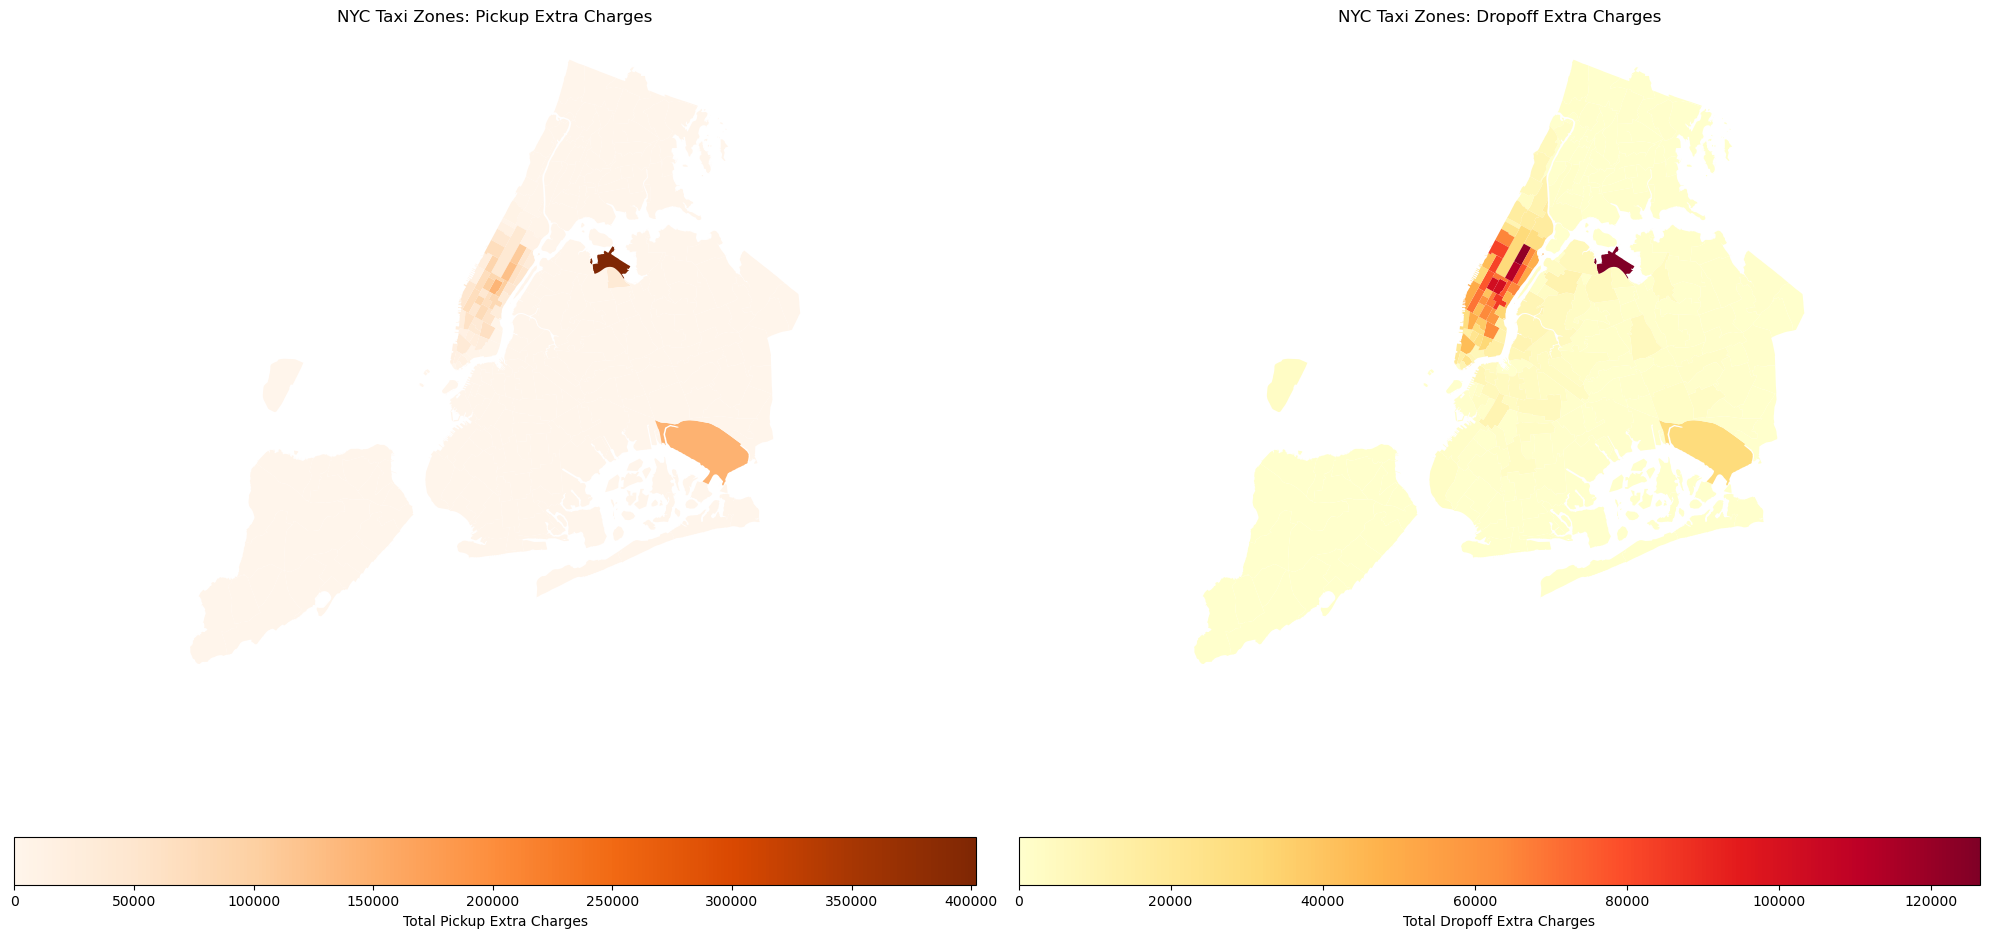

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Pickup extra charges
merged_zones.plot(
    column='pickup_extra',
    cmap='Oranges',
    legend=True,
    legend_kwds={'label': 'Total Pickup Extra Charges', 'orientation': 'horizontal'},
    ax=axes[0]
)
axes[0].set_title('NYC Taxi Zones: Pickup Extra Charges')
axes[0].axis('off')

# Dropoff extra charges
merged_zones.plot(
    column='dropoff_extra',
    cmap='YlOrRd',
    legend=True,
    legend_kwds={'label': 'Total Dropoff Extra Charges', 'orientation': 'horizontal'},
    ax=axes[1]
)
axes[1].set_title('NYC Taxi Zones: Dropoff Extra Charges')
axes[1].axis('off')

plt.tight_layout()
plt.show()


## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

# Strategic Cab Positioning Across Zones

## 1. Time of Day Positioning
- **Early Morning (5–8 AM):** Focus on residential areas, airports, and transit hubs in outer boroughs.
- **Morning Peak (8–10 AM):** Position near subway exits and bus terminals in Manhattan.
- **Midday (10 AM–3 PM):** Maintain steady availability near tourist spots and commercial areas; rotate idle cabs.
- **Evening Rush (5–8 PM):** Stage near office districts and event venues.
- **Nighttime (8 PM–2 AM):** Concentrate on nightlife hubs.
- **Late Night (2–5 AM):** Cover airports, hospitals, and late-night venues.

## 2. Day of Week Strategy
- **Weekdays (Mon–Thu):** Prioritize office zones and transit hubs.
- **Weekends (Fri–Sun):**  
  - Friday: Extend service into evenings near entertainment/business areas.  
  - Saturday: Focus on shopping, tourist, and nightlife zones.  
  - Sunday: Target brunch spots, parks, airports, and churches.

## 3. Seasonal Adjustments
- **Winter:** Increase service in residential and indoor venues.  
- **Spring/Summer:** Deploy near parks, beaches, ferry terminals, and events.  
- **Fall:** Align with commuting and school schedules.

## 4. Special Considerations
- Pre-position cabs for major events.  
- Increase coverage during bad weather.  
- Encourage ride pooling in busy zones.


**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

# Proposed Pricing Strategy Adjustments

## 1. Dynamic Pricing by Time
- **Peak Hours (Morning & Evening):**  
  - Raise base fare or add a 5–15% surcharge during peak demand.  
  - Implement per-mile rates that increase with traffic congestion.

- **Late Night (11 PM – 5 AM):**  
  - Slightly increase fare per mile.  
  - Keep base fare competitive with ride-hailing apps.  
  - Apply or maintain night surcharges to reflect added service and safety.

## 2. Tailored Vendor Pricing
- For vendors with fewer long-distance trips (Vendor A), provide discounts on trips over 5 miles to encourage longer rides.  
- For vendors attracting higher tips and fares (Vendor B), maintain premium pricing but add loyalty rewards.  
- Align pricing models to leverage each vendor’s strengths, like long-haul service or faster trips in busy areas.

## 3. Zone-Based Pricing
- **High-Demand Areas (e.g., airports, Midtown):**  
  - Introduce zone-specific surcharges.  
  - Offer flat fares for popular routes (e.g., JFK to Midtown).

- **Low-Demand or Congested Zones:**  
  - Provide fare incentives or driver bonuses to boost service coverage.

## 4. Encourage High Tips
- Highlight tipping prompts during high-tip periods like late nights or larger groups.  
- Consider premium service options (e.g., music, phone charging) to boost customer satisfaction and tips.

## 5. Transparency & Predictability
- Clearly communicate pricing tiers, surcharges, and peak time changes to customers.  
- Provide fare estimators to reduce uncertainty and improve trust.
